In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os

# Load point cloud data from a PLY file
def load_point_cloud(file_path):
    """
    Load point cloud data from a PLY file using Open3D.

    Parameters:
    file_path (str): The file path of the PLY file.

    Returns:
    np.ndarray: A NumPy array containing the point cloud data.
    """
    point_cloud = o3d.io.read_point_cloud(file_path)
    return np.asarray(point_cloud.points)

# Normalize Z values so that the lowest point has Z=0
def normalize_z(points):
    """
    Normalize the Z values of the point cloud so that the lowest point is set to Z=0.

    Parameters:
    points (np.ndarray): A NumPy array containing the point cloud data.

    Returns:
    np.ndarray: The normalized point cloud data with Z=0 as the lowest point.
    """
    z_min = points[:, 2].min()
    points[:, 2] -= z_min
    return points

# Slice the point cloud along the Z axis
def get_slices(points, z_start, z_end, slice_thickness=0.1):
    """
    Slice the point cloud along the Z axis at regular intervals.

    Parameters:
    points (np.ndarray): The point cloud data as a NumPy array.
    z_start (float): The starting Z value for slicing.
    z_end (float): The ending Z value for slicing.
    slice_thickness (float): The thickness of each slice along the Z axis (default is 0.1 meters).

    Returns:
    list: A list of 2D slices, where each slice is a NumPy array of points.
    """
    slices = []
    z_values = np.arange(z_start, z_end, slice_thickness)
    for z in z_values:
        slice_points = points[(points[:, 2] >= z) & (points[:, 2] < z + slice_thickness)]
        if len(slice_points) > 0:
            slices.append(slice_points)
    return slices

# Project the 2D slice points onto the X axis
def project_to_x_axis(slice_points):
    """
    Project the 2D slice points onto the X axis.

    Parameters:
    slice_points (np.ndarray): A NumPy array containing the points in the current slice.

    Returns:
    np.ndarray: The X coordinates of the projected points.
    """
    return slice_points[:, 0]

# Calculate a normalized histogram of point density
def calculate_histogram(projection, bins=50, range=None):
    """
    Calculate a normalized histogram of the point density for the projected points.

    Parameters:
    projection (np.ndarray): The projected X coordinates.
    bins (int): The number of bins for the histogram (default is 50).
    range (tuple): The range of values for the histogram (optional).

    Returns:
    tuple: A tuple containing the histogram and bin edges.
    """
    hist, bin_edges = np.histogram(projection, bins=bins, range=range)
    hist = hist / np.sum(hist)  # Normalize the histogram to total count
    return hist, bin_edges

# Visualize the 2D slice and projection results
def visualize_slice_and_projection(slice_tls, slice_polycam, projection_tls, projection_polycam, z_value, output_dir, tree_name, bins=50):
    """
    Visualize the 2D slice and corresponding projection histograms for TLS and Polycam.

    Parameters:
    slice_tls (np.ndarray): The 2D slice points for the TLS data.
    slice_polycam (np.ndarray): The 2D slice points for the Polycam data.
    projection_tls (np.ndarray): The X axis projection of the TLS points.
    projection_polycam (np.ndarray): The X axis projection of the Polycam points.
    z_value (float or str): The Z value of the slice (can be a number or 'Overall' for complete comparison).
    output_dir (str): The directory where the visualizations will be saved.
    tree_name (str): The name of the tree being analyzed.
    bins (int): The number of bins for the histogram (default is 50).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the 2D slice view for TLS and Polycam
    axes[0].scatter(slice_tls[:, 0], slice_tls[:, 1], color='blue', alpha=0.5, label='TLS')
    axes[0].scatter(slice_polycam[:, 0], slice_polycam[:, 1], color='orange', alpha=0.5, label='Polycam')
    
    if isinstance(z_value, str):
        axes[0].set_title(f'2D Slice at {z_value} for {tree_name}')
        z_value_str = z_value  # If z_value is a string, use it directly
    else:
        axes[0].set_title(f'2D Slice at Z={z_value:.2f} for {tree_name}')
        z_value_str = f'{z_value:.2f}'  # If z_value is numeric, format to two decimal places

    axes[0].set_xlabel('X axis (meters)')
    axes[0].set_ylabel('Y axis (meters)')
    axes[0].legend()

    # Calculate and plot the projection histograms
    range_min = min(projection_tls.min(), projection_polycam.min())
    range_max = max(projection_tls.max(), projection_polycam.max())
    
    hist_tls, bin_edges = calculate_histogram(projection_tls, bins=bins, range=(range_min, range_max))
    hist_polycam, _ = calculate_histogram(projection_polycam, bins=bins, range=(range_min, range_max))

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    axes[1].bar(bin_centers, hist_tls, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='blue', label='TLS')
    axes[1].bar(bin_centers, hist_polycam, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='orange', label='Polycam')

    axes[1].set_title(f'Projection Histogram at {z_value_str} for {tree_name}')
    axes[1].set_xlabel('X axis (meters)')
    axes[1].set_ylabel('Normalized Frequency')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'slice_projection_z_{z_value_str}.png'))
    plt.close()

# Calculate the absolute sum of differences between two histograms
def calculate_histogram_ratio_difference(hist1, hist2):
    """
    Calculate the sum of absolute differences between two histograms.

    Parameters:
    hist1 (np.ndarray): The first histogram.
    hist2 (np.ndarray): The second histogram.

    Returns:
    float: The total absolute difference between the two histograms.
    """
    return np.sum(np.abs(hist1 - hist2))

# Visualize the histogram ratio differences across all slices
def visualize_slice_differences(z_values, differences, output_dir, tree_name):
    """
    Visualize the histogram ratio differences across slices.

    Parameters:
    z_values (np.ndarray): An array of Z values representing the height of each slice.
    differences (list): A list of histogram ratio differences between TLS and Polycam for each slice.
    output_dir (str): The directory where the visualizations will be saved.
    tree_name (str): The name of the tree being analyzed.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z_values, differences, marker='o', linestyle='-', color='b', label=tree_name)
    plt.xlabel('Z (meters)')
    plt.ylabel('Histogram Ratio Difference')
    plt.title(f'Histogram Ratio Difference between TLS and Polycam projections for {tree_name}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'histogram_ratio_differences.png'))
    plt.close()

# Automatically extract the tree name from the file path
def extract_tree_name(file_path):
    """
    Extract the tree name from the file path.

    Parameters:
    file_path (str): The file path of the PLY file.

    Returns:
    str: The extracted tree name.
    """
    base_name = os.path.basename(file_path)
    # Assuming the file name format is "<tree_name> TLS.ply" or "<tree_name> polycam.ply"
    tree_name = base_name.split(' TLS')[0] if 'TLS' in base_name else base_name.split(' polycam')[0]
    return tree_name

# Main function to execute the comparison
def main():
    """
    Main function that executes the comparison of TLS and Polycam point clouds.
    It normalizes the Z values, slices the point clouds, projects the slices onto the X axis,
    and calculates histogram differences, visualizing the results for each slice.
    Finally, the results are written to a TXT file.
    """
    # Define the input file paths
    tls_file_path = r"C:\Users\wenru\Desktop\COMPARE\pwllpriddog TLS.ply"
    polycam_file_path = r"C:\Users\wenru\Desktop\COMPARE\pwllpriddog polycam.ply"

    # Extract the tree name from the file path
    tree_name = extract_tree_name(tls_file_path)

    # Create the output directory
    output_dir = os.path.join(r"C:\Users\wenru\Desktop", f"{tree_name}_output")
    os.makedirs(output_dir, exist_ok=True)

    # Create a TXT file to save parameters and differences
    param_file_path = os.path.join(output_dir, "parameters.txt")
    with open(param_file_path, 'w') as param_file:

        # Load the point cloud data
        points_tls = load_point_cloud(tls_file_path)
        points_polycam = load_point_cloud(polycam_file_path)

        # Normalize Z values so that the lowest point is at Z=0
        points_tls = normalize_z(points_tls)
        points_polycam = normalize_z(points_polycam)

        # Define slice thickness
        slice_thickness = 0.1

        # Automatically calculate the Z range from the minimum to the maximum Z value
        z_min = 0  # Already normalized, the minimum Z value is 0
        z_max = min(points_tls[:, 2].max(), points_polycam[:, 2].max())  # The lower of the two maximum Z values
        z_values = np.arange(z_min, z_max, slice_thickness)

        # Initialize variables to store differences and Z values
        differences = []

        # For each slice, project the points and compare histograms
        for z in z_values:
            slice_tls = points_tls[(points_tls[:, 2] >= z) & (points_tls[:, 2] < z + slice_thickness)]
            slice_polycam = points_polycam[(points_polycam[:, 2] >= z) & (points_polycam[:, 2] < z + slice_thickness)]

            if len(slice_tls) == 0 or len(slice_polycam) == 0:
                print(f"Reached empty slice at Z={z:.2f}. Stopping.")
                break

            # Project the slice points onto the X axis
            projection_tls = project_to_x_axis(slice_tls)
            projection_polycam = project_to_x_axis(slice_polycam)

            # Calculate the histograms
            hist_tls, _ = calculate_histogram(projection_tls)
            hist_polycam, _ = calculate_histogram(projection_polycam)

            # Calculate the difference between the histograms
            diff = calculate_histogram_ratio_difference(hist_tls, hist_polycam)
            differences.append(diff)
            
            # Visualize each slice's 2D view and projection histograms
            visualize_slice_and_projection(slice_tls, slice_polycam, projection_tls, projection_polycam, z, output_dir, tree_name)
            
            # Write the histogram ratio difference for each slice to the TXT file
            param_file.write(f'Z={z:.2f}: Histogram Ratio Difference = {diff:.4f}\n')

        # Visualize the histogram ratio differences across all slices
        visualize_slice_differences(z_values[:len(differences)], differences, output_dir, tree_name)

        # Calculate the total and average differences
        total_diff = np.nansum(differences)  # Ignore NaN values when calculating the total difference
        average_diff = np.nanmean(differences)  # Ignore NaN values when calculating the average difference

        # Write the total and average differences to the TXT file
        param_file.write(f'\nTotal Histogram Ratio Difference: {total_diff}\n')
        param_file.write(f'Average Histogram Ratio Difference per slice: {average_diff}\n')

        # Filter the points within the traversed Z range
        points_tls_filtered = points_tls[(points_tls[:, 2] >= z_min) & (points_tls[:, 2] <= z)]
        points_polycam_filtered = points_polycam[(points_polycam[:, 2] >= z_min) & (points_polycam[:, 2] <= z)]

        # Project the entire Z range onto the X axis and calculate histograms
        overall_projection_tls = project_to_x_axis(points_tls_filtered)
        overall_projection_polycam = project_to_x_axis(points_polycam_filtered)
        
        overall_hist_tls, _ = calculate_histogram(overall_projection_tls)
        overall_hist_polycam, _ = calculate_histogram(overall_projection_polycam)
        
        # Visualize the overall projection results
        overall_diff = calculate_histogram_ratio_difference(overall_hist_tls, overall_hist_polycam)
        visualize_slice_and_projection(points_tls_filtered, points_polycam_filtered, overall_projection_tls, overall_projection_polycam, z_value='Overall', output_dir=output_dir, tree_name=tree_name)
        
        # Write the overall histogram ratio difference to the TXT file
        param_file.write(f'\nTotal Histogram Ratio Difference for overall projection: {overall_diff:.4f}\n')

if __name__ == "__main__":
    main()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Enter the start of the Z range (in meters): 0
Enter the end of the Z range (in meters): 3.4


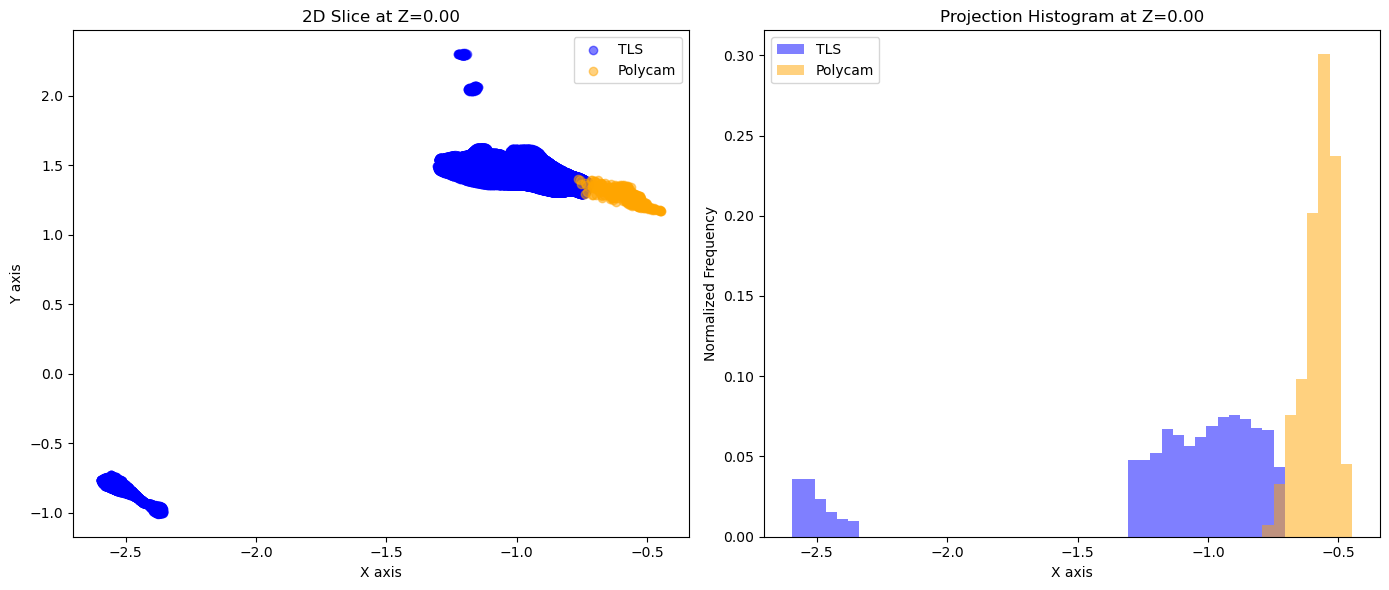

Histogram Ratio Difference at Z=0.00: 1.3401


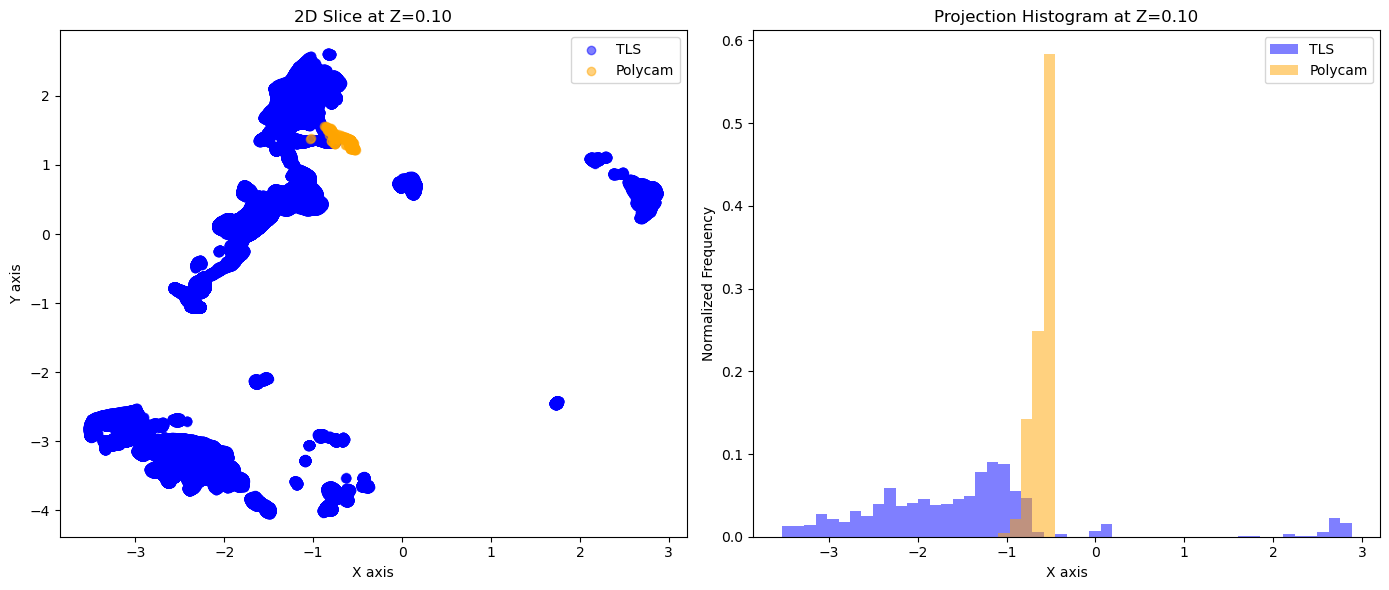

Histogram Ratio Difference at Z=0.10: 1.7356


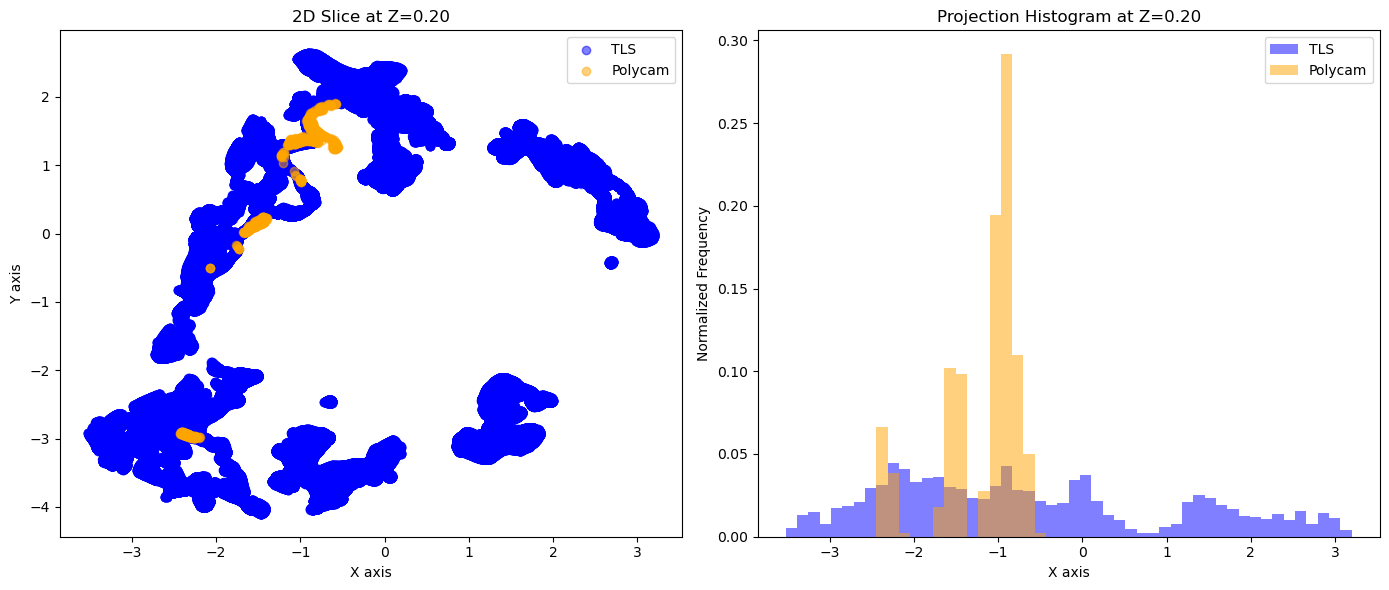

Histogram Ratio Difference at Z=0.20: 1.0941


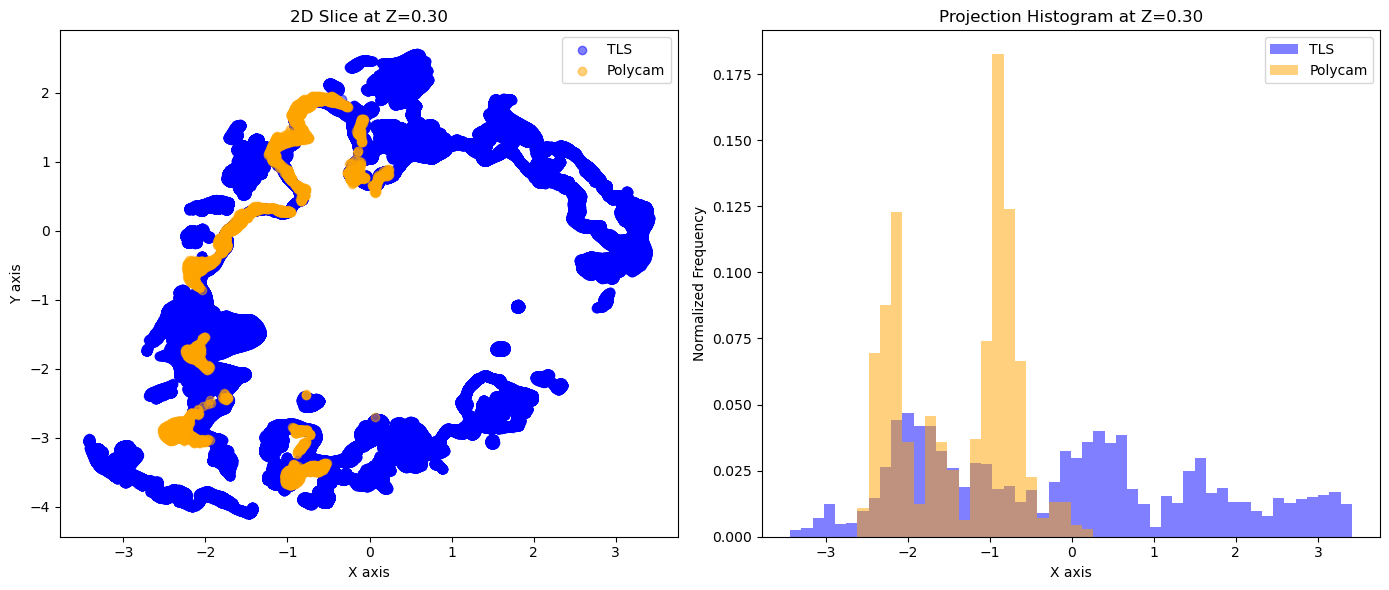

Histogram Ratio Difference at Z=0.30: 0.9037


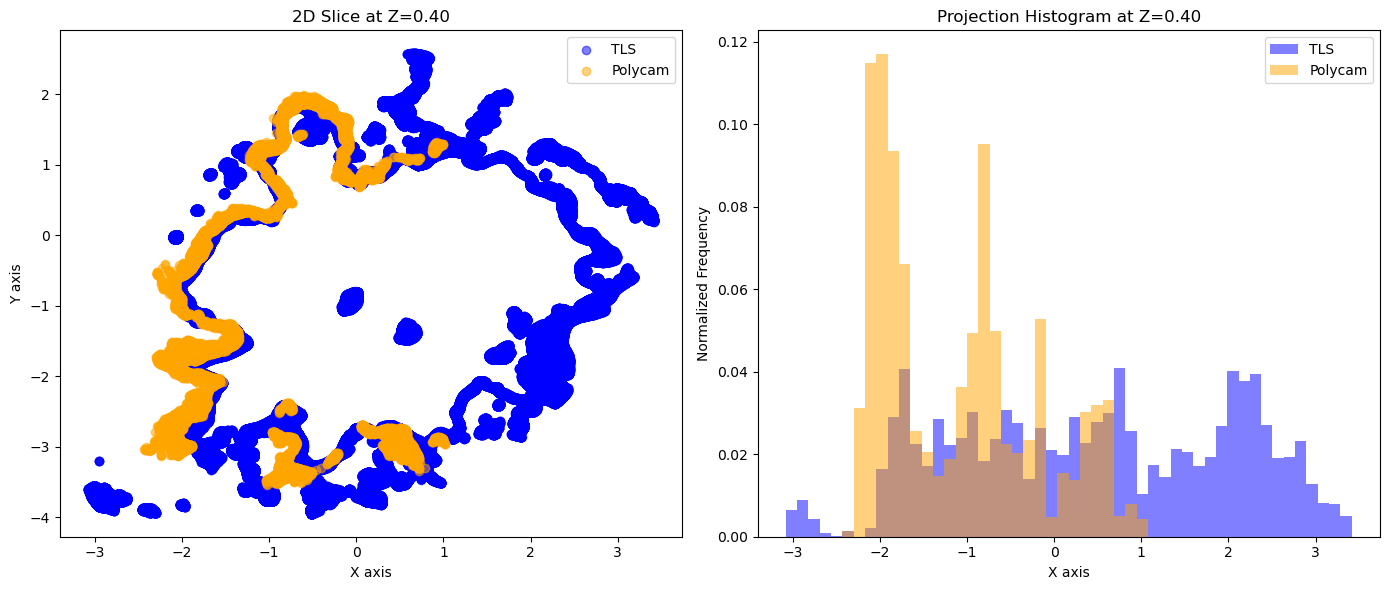

Histogram Ratio Difference at Z=0.40: 0.8679


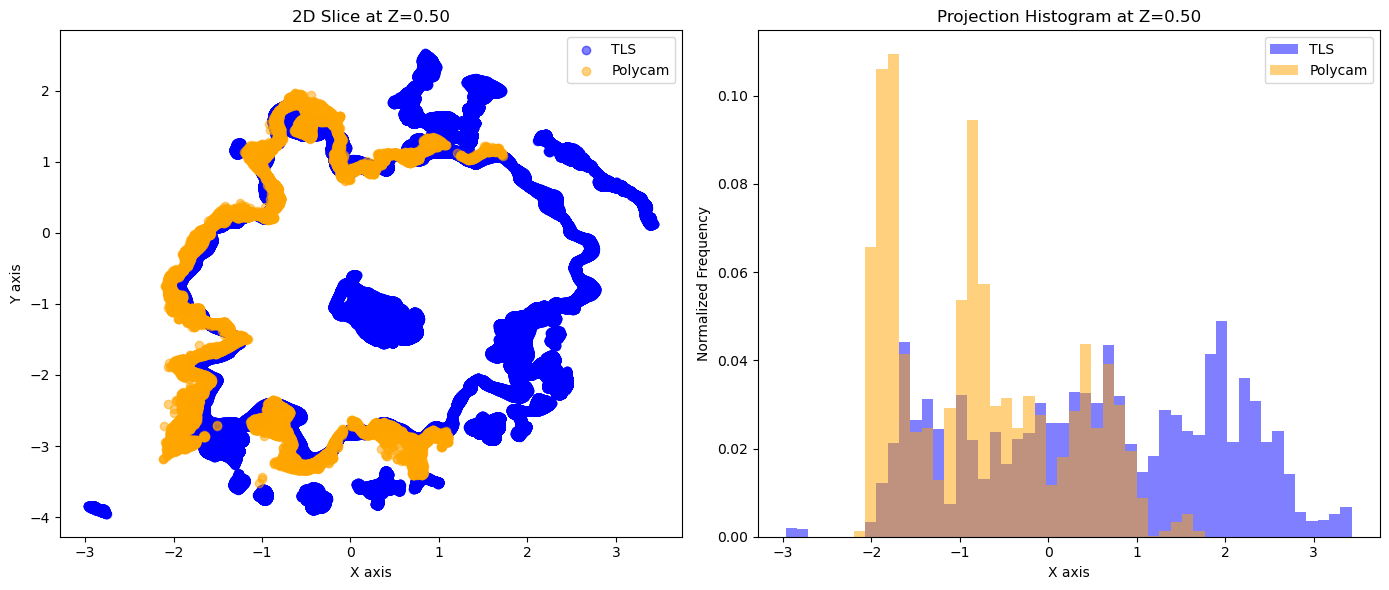

Histogram Ratio Difference at Z=0.50: 0.9141


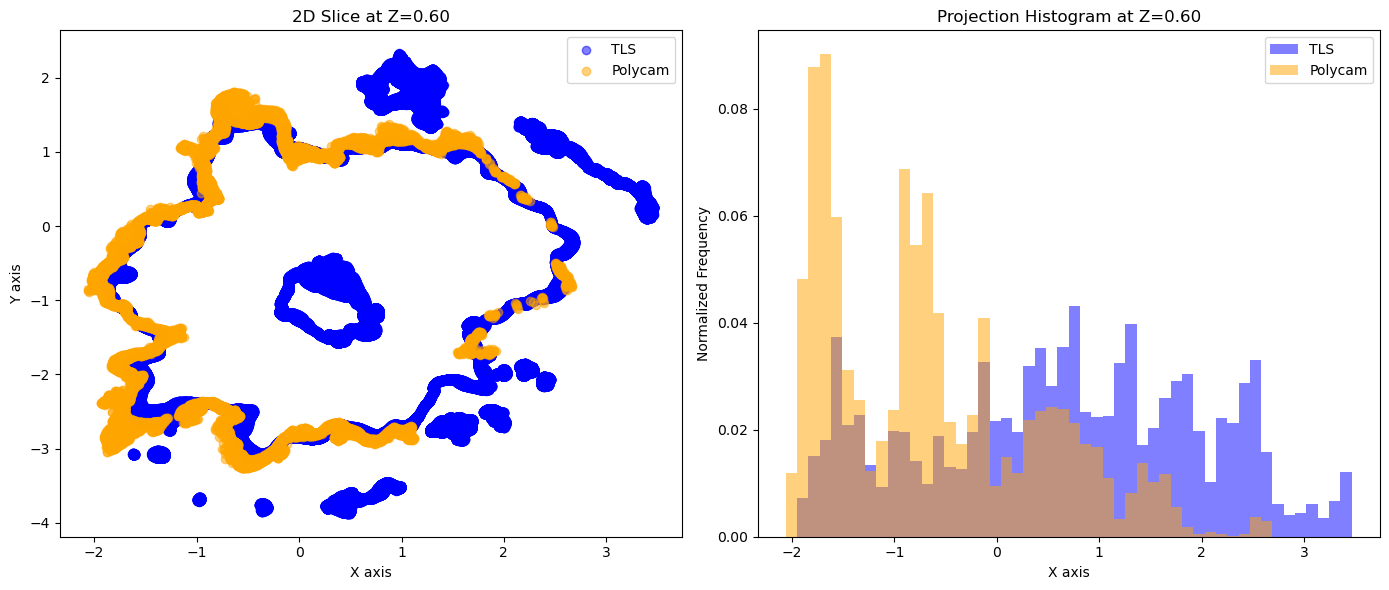

Histogram Ratio Difference at Z=0.60: 0.7790


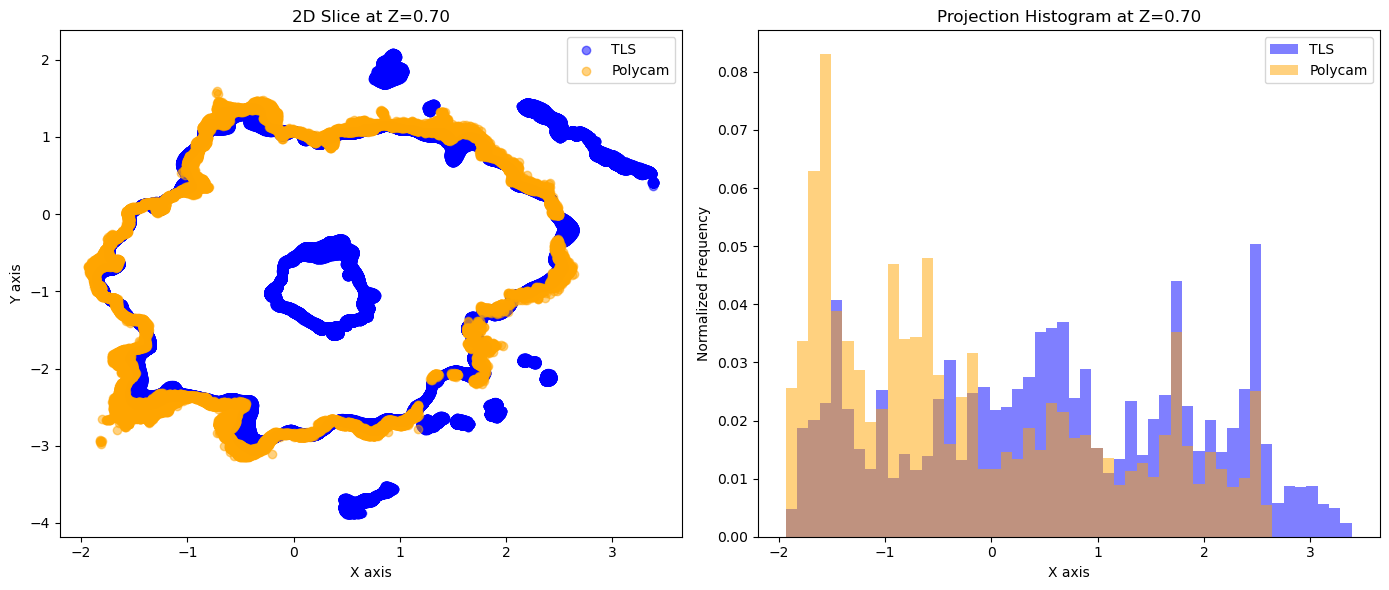

Histogram Ratio Difference at Z=0.70: 0.5814


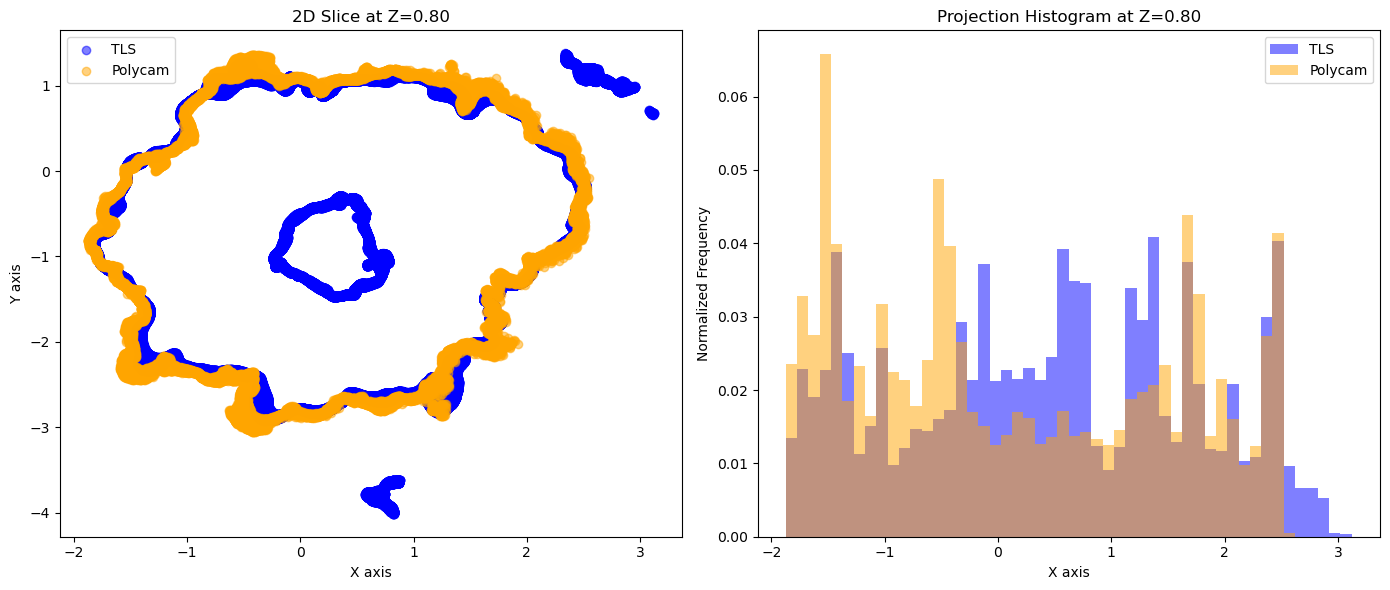

Histogram Ratio Difference at Z=0.80: 0.5470


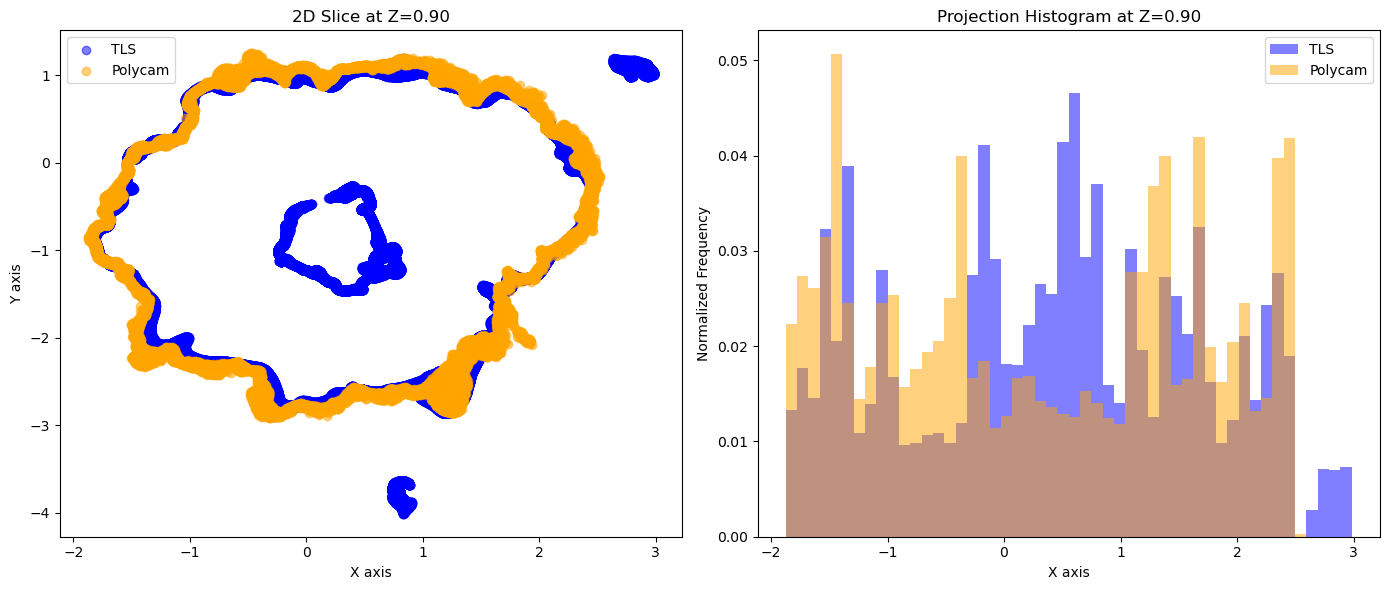

Histogram Ratio Difference at Z=0.90: 0.5117


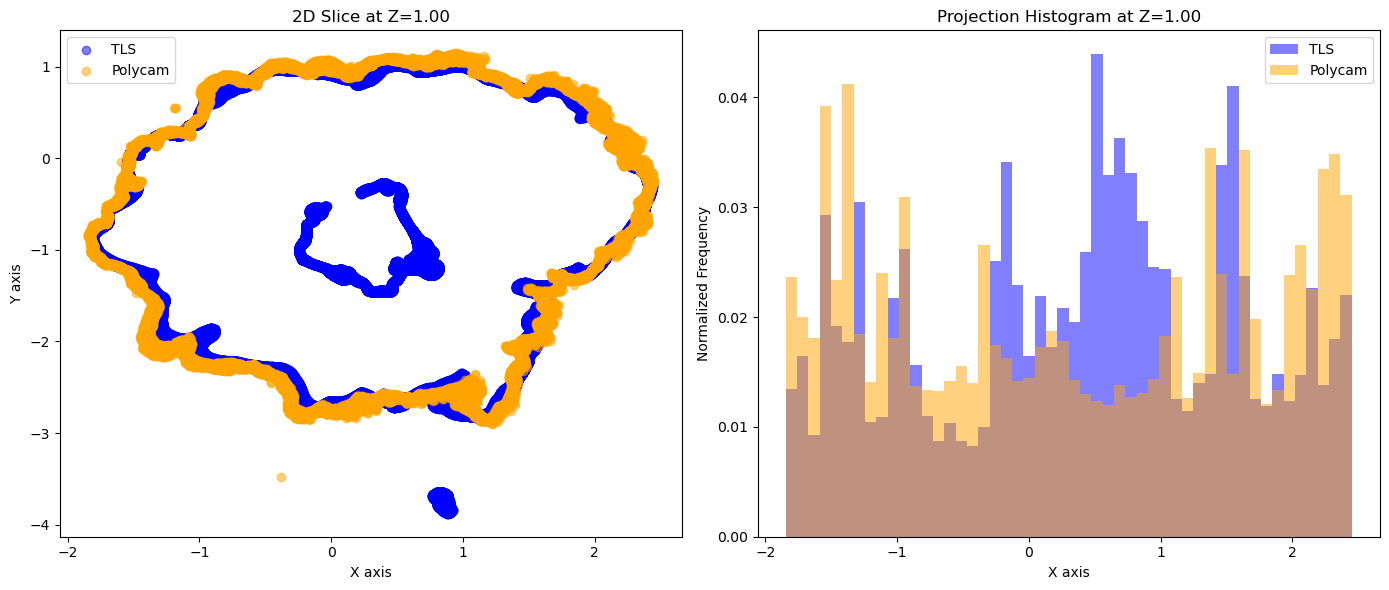

Histogram Ratio Difference at Z=1.00: 0.4847


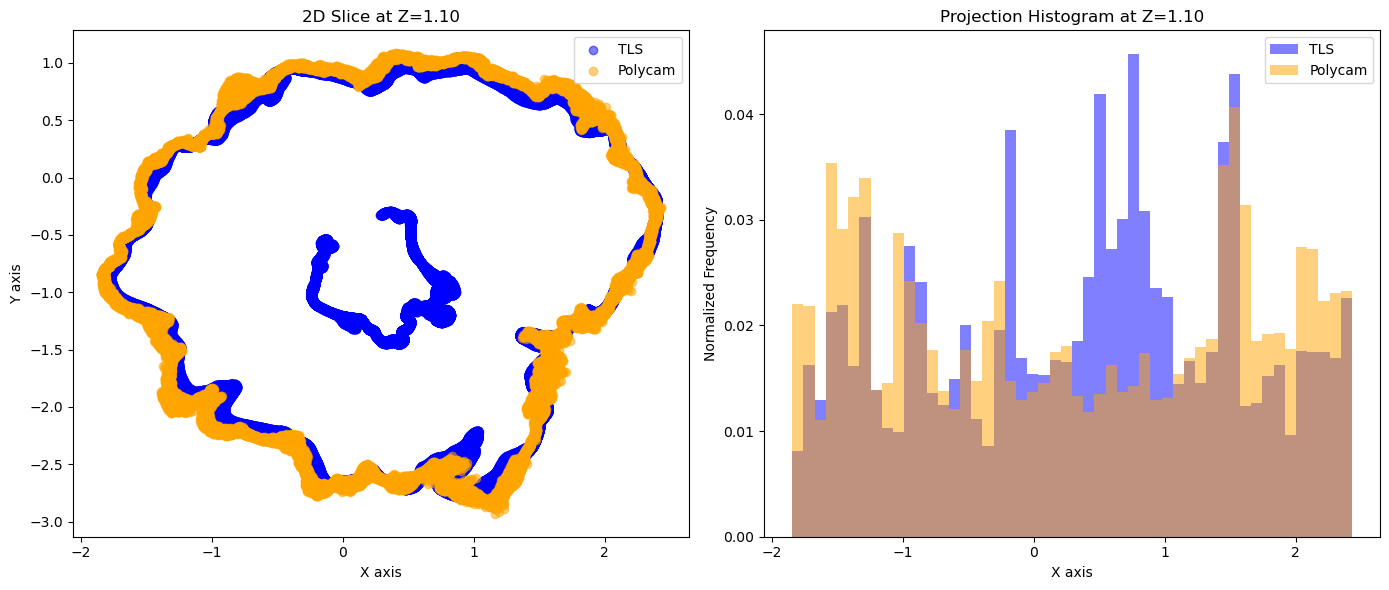

Histogram Ratio Difference at Z=1.10: 0.3626


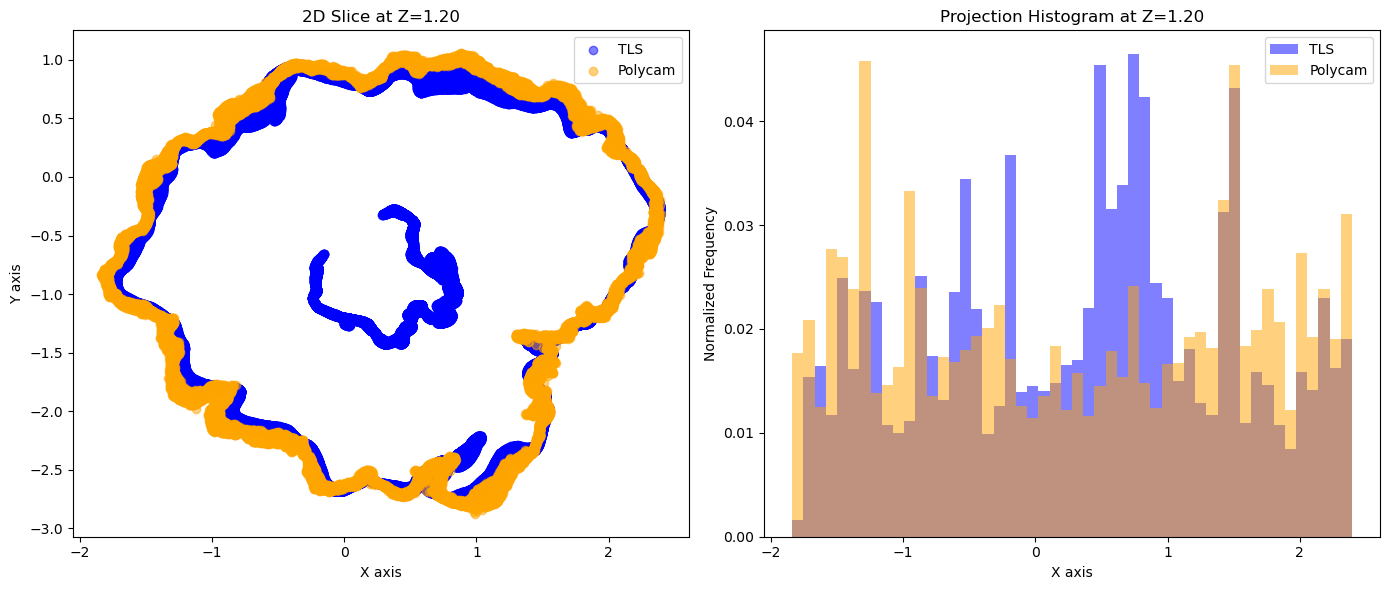

Histogram Ratio Difference at Z=1.20: 0.3757


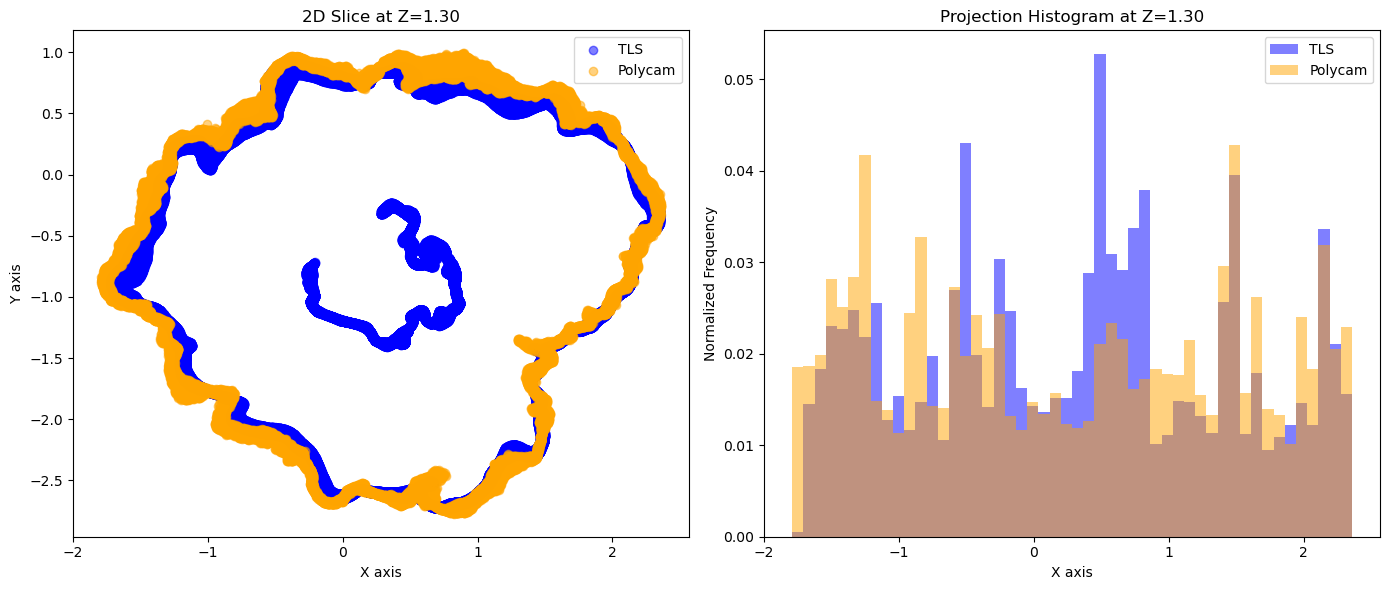

Histogram Ratio Difference at Z=1.30: 0.3284


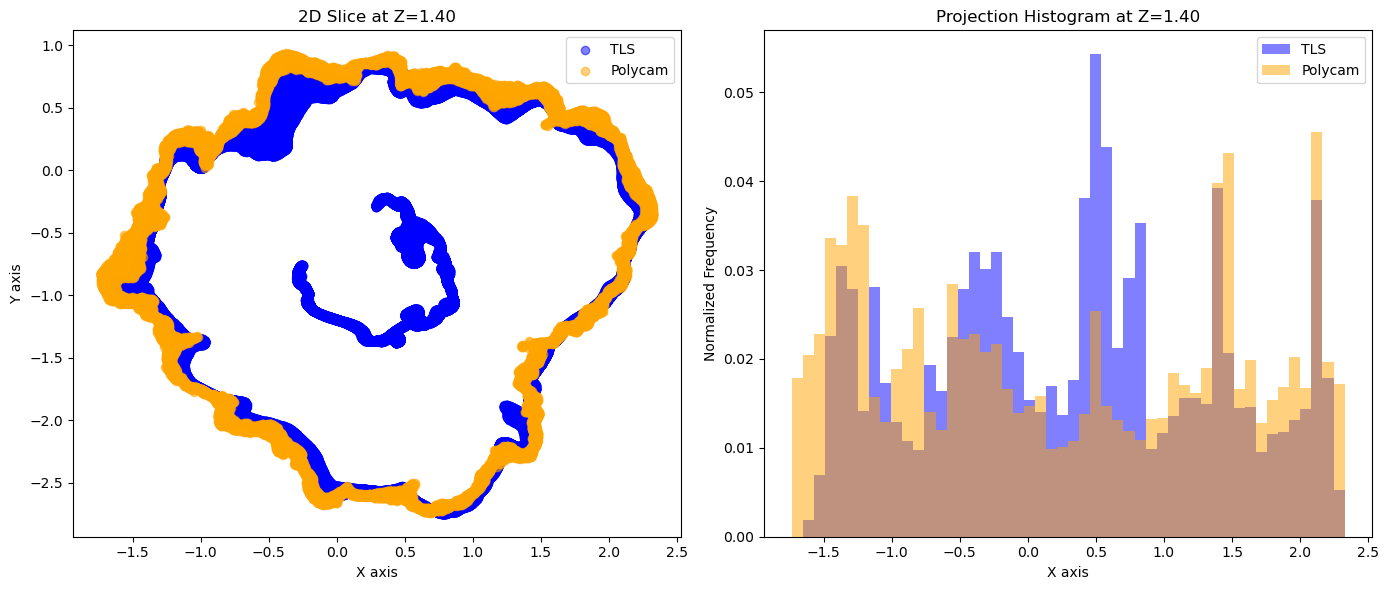

Histogram Ratio Difference at Z=1.40: 0.3962


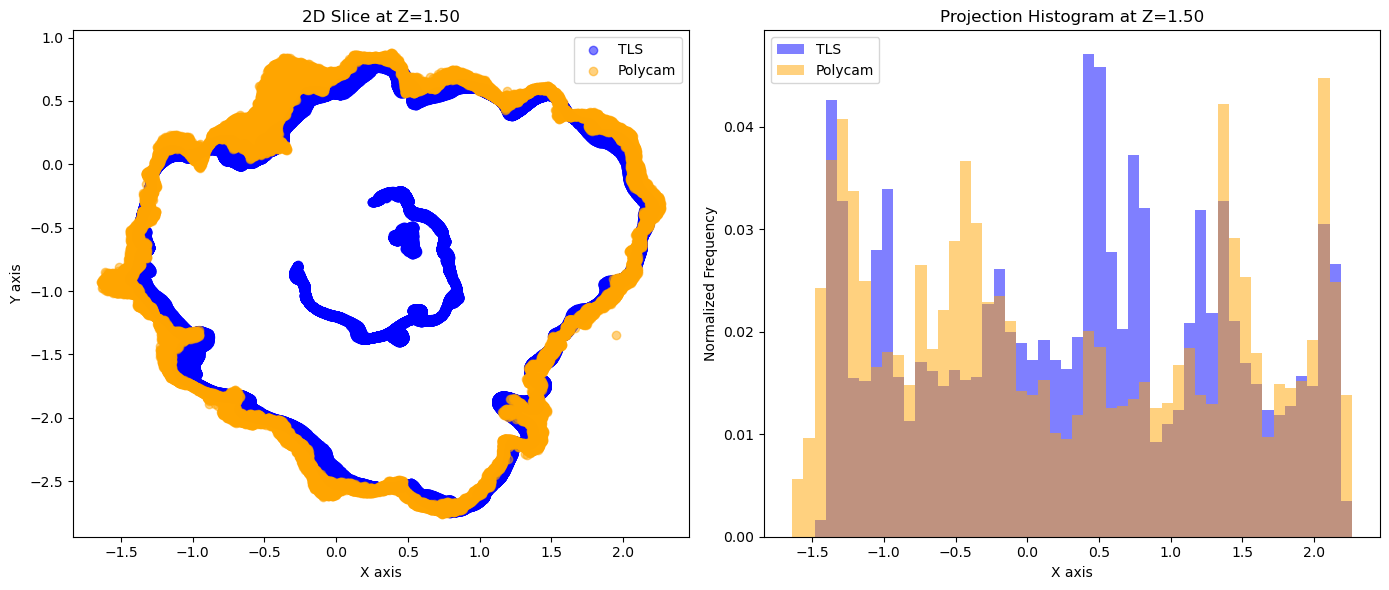

Histogram Ratio Difference at Z=1.50: 0.4500


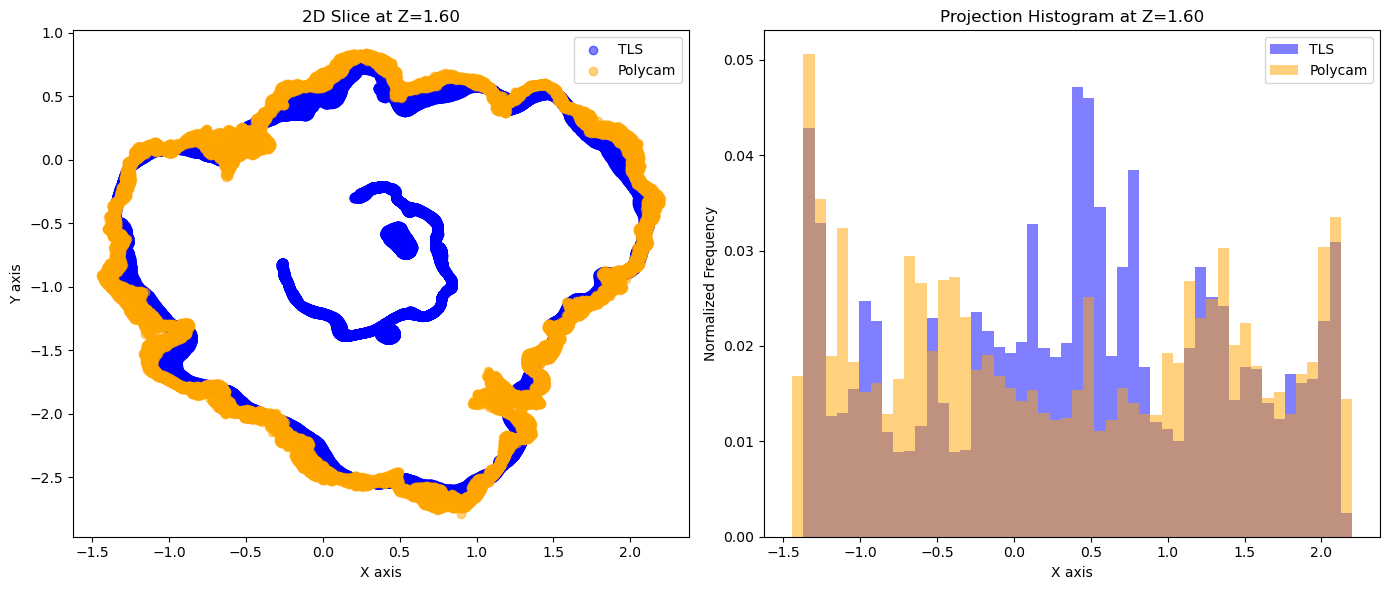

Histogram Ratio Difference at Z=1.60: 0.4498


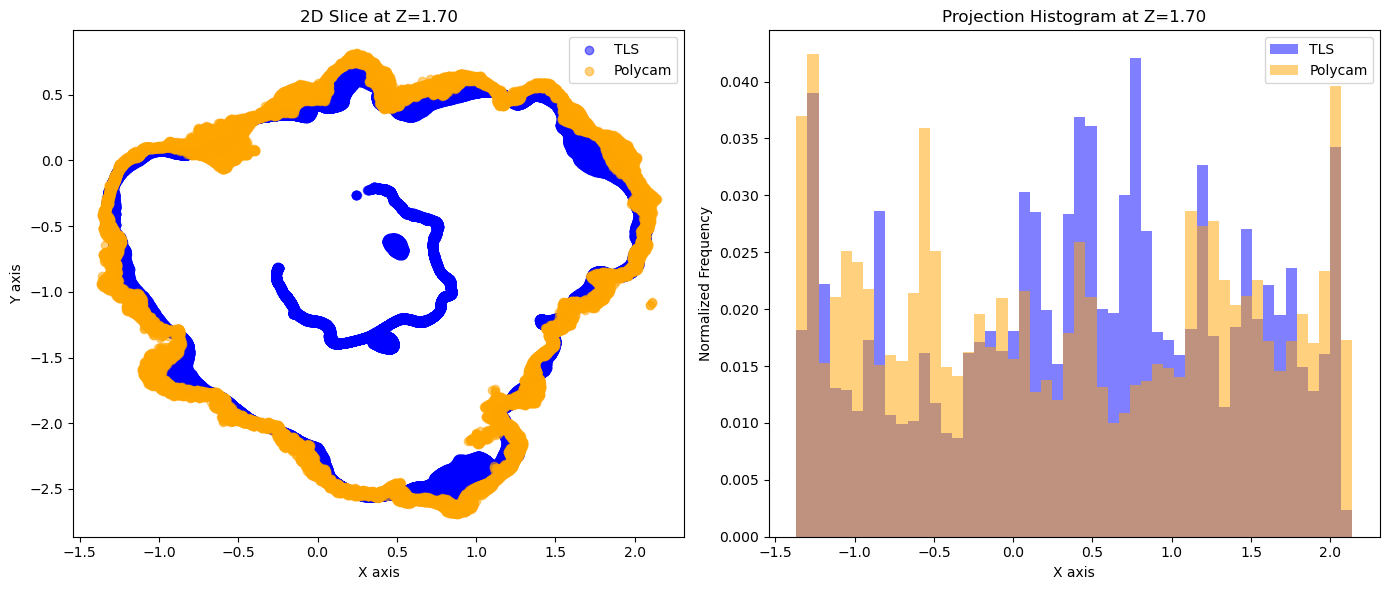

Histogram Ratio Difference at Z=1.70: 0.3847


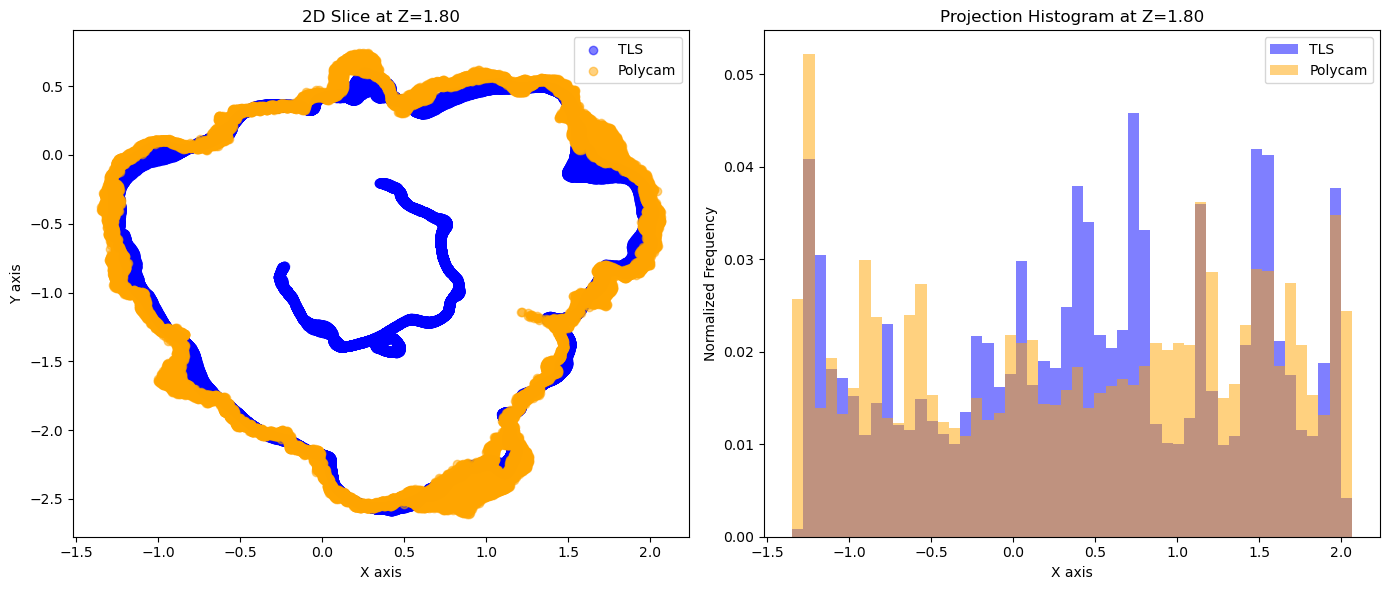

Histogram Ratio Difference at Z=1.80: 0.3930


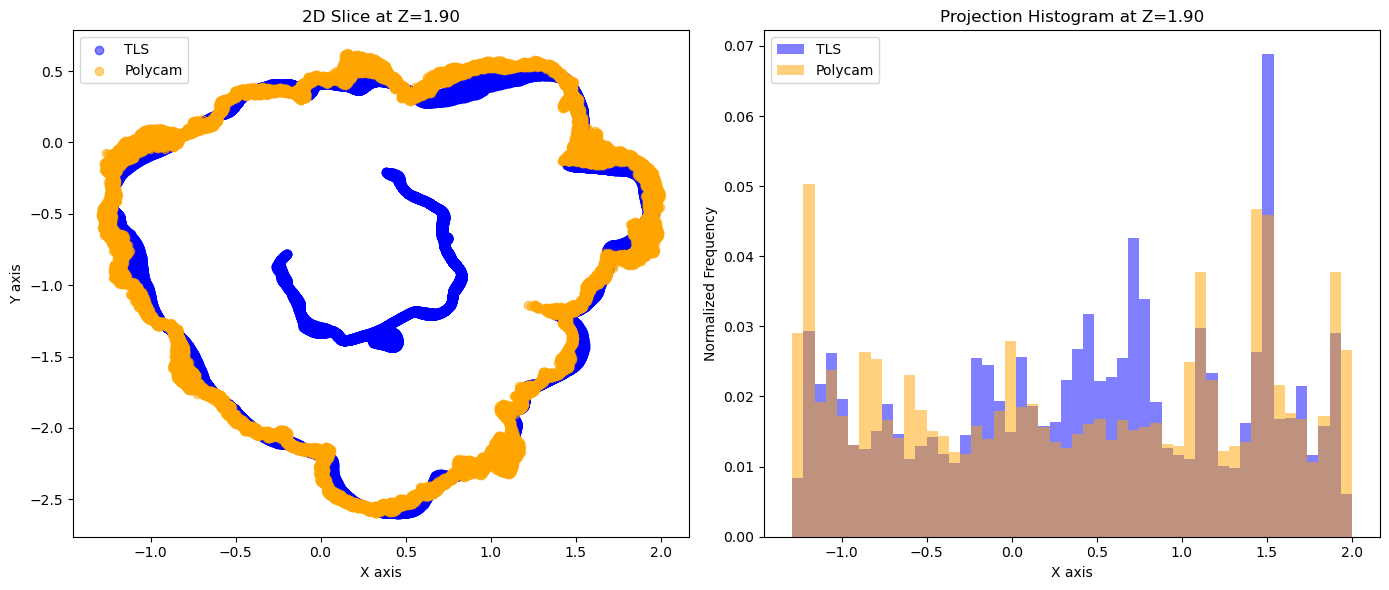

Histogram Ratio Difference at Z=1.90: 0.3974


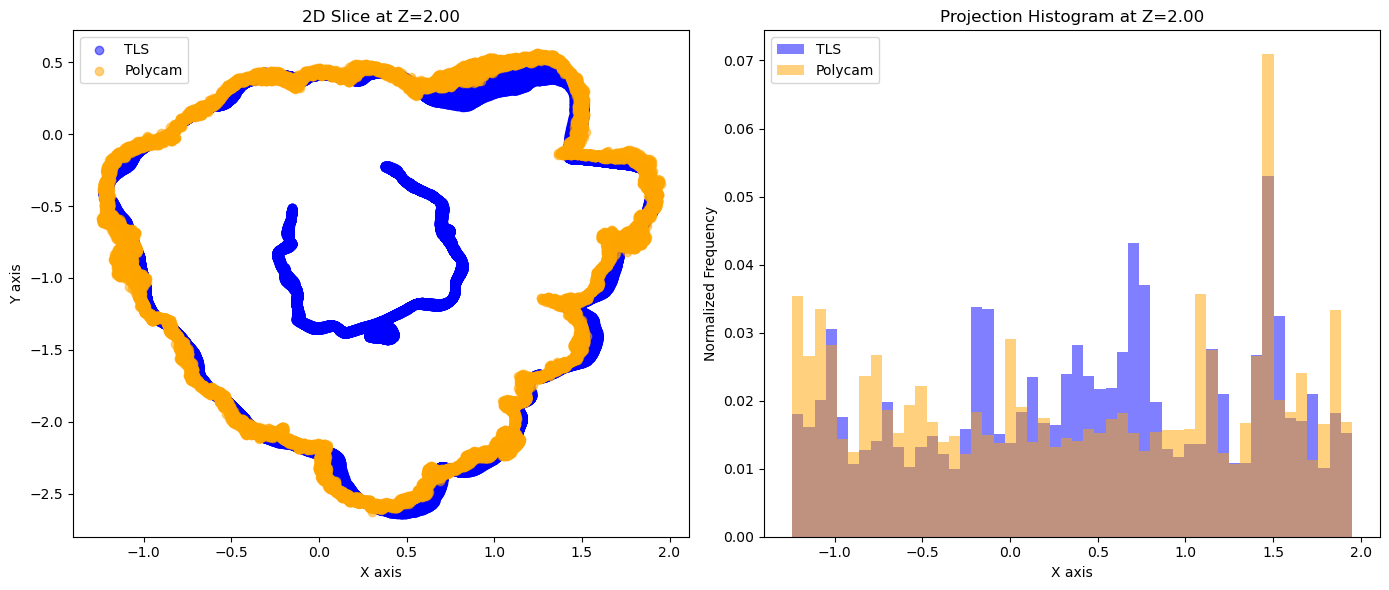

Histogram Ratio Difference at Z=2.00: 0.4408


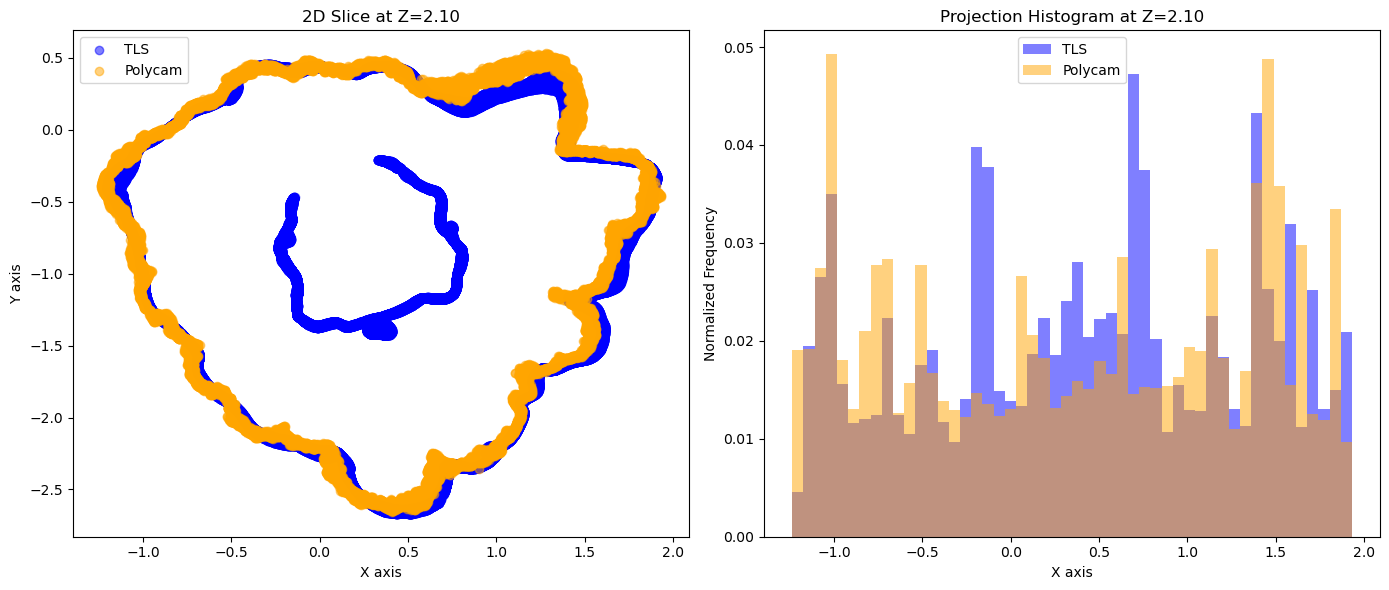

Histogram Ratio Difference at Z=2.10: 0.4255


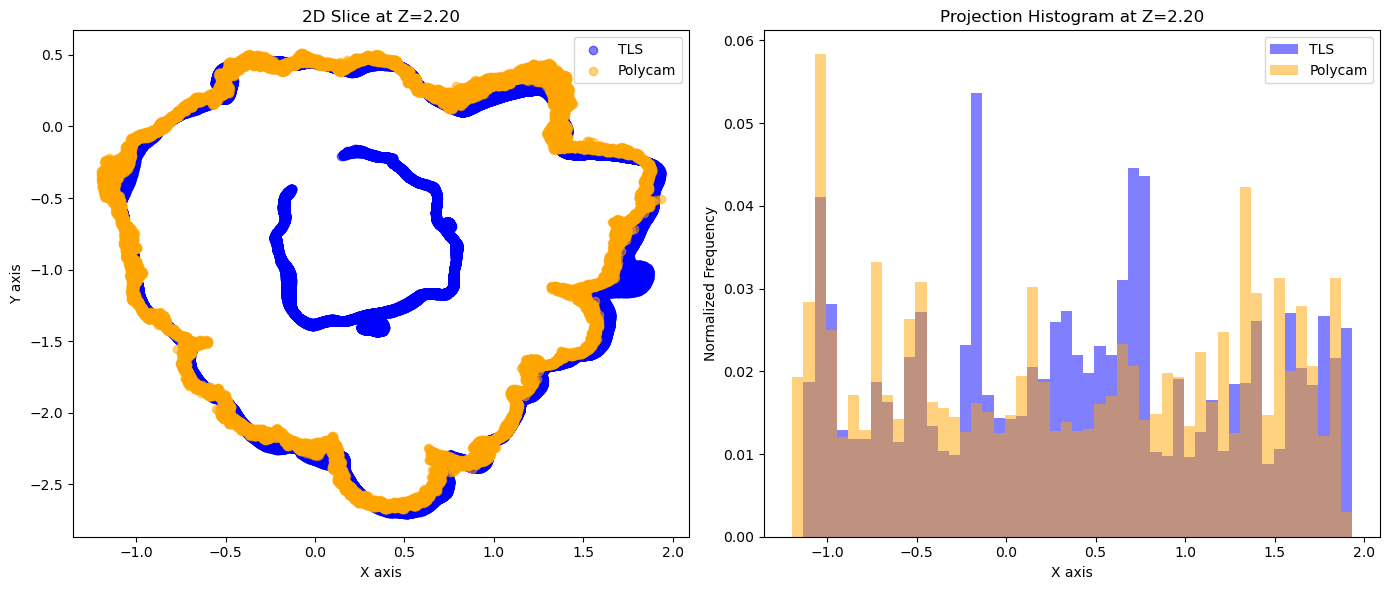

Histogram Ratio Difference at Z=2.20: 0.4634


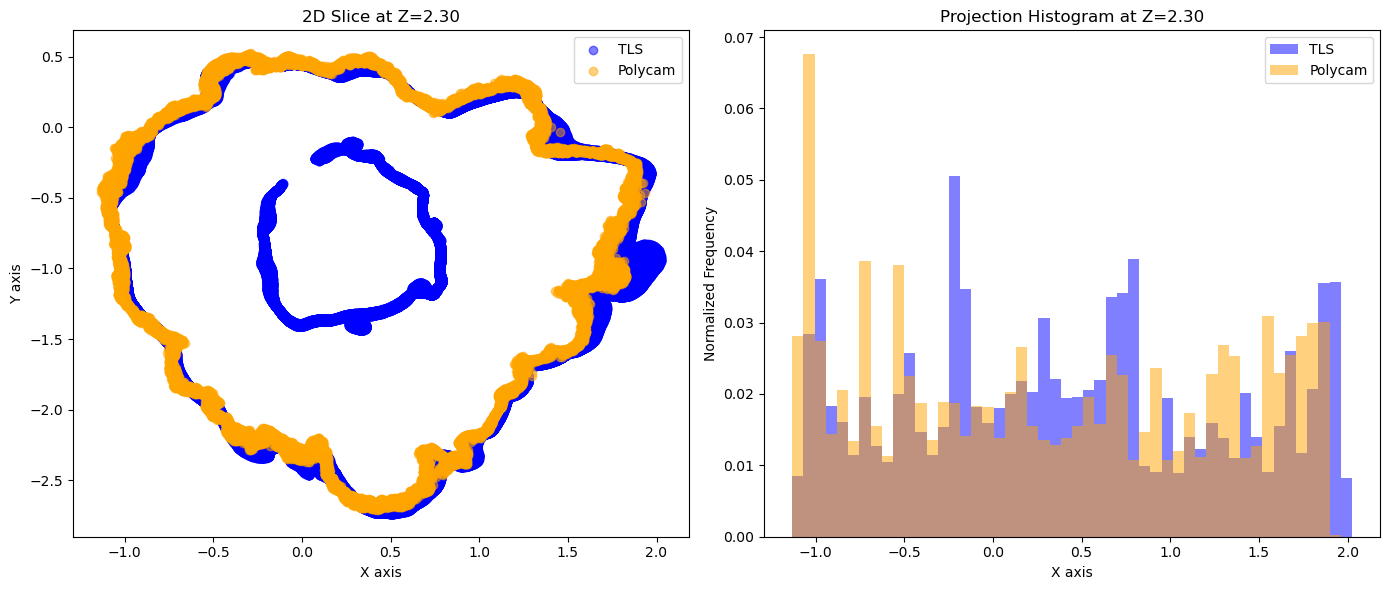

Histogram Ratio Difference at Z=2.30: 0.3650


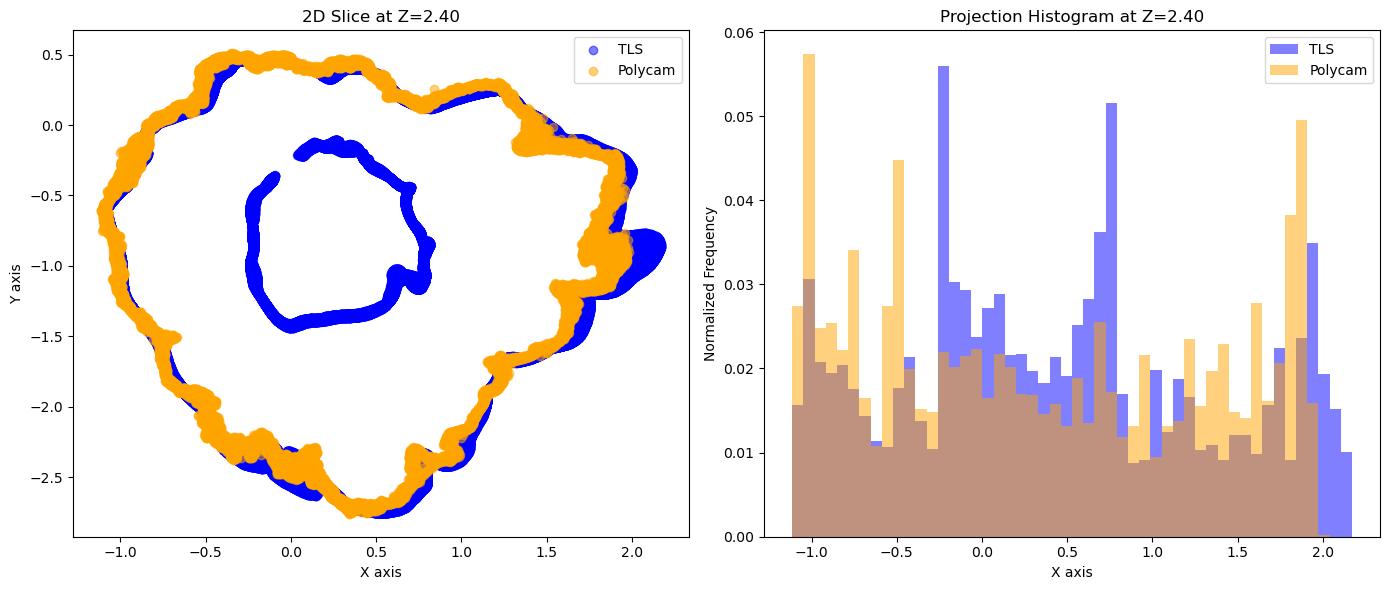

Histogram Ratio Difference at Z=2.40: 0.4889


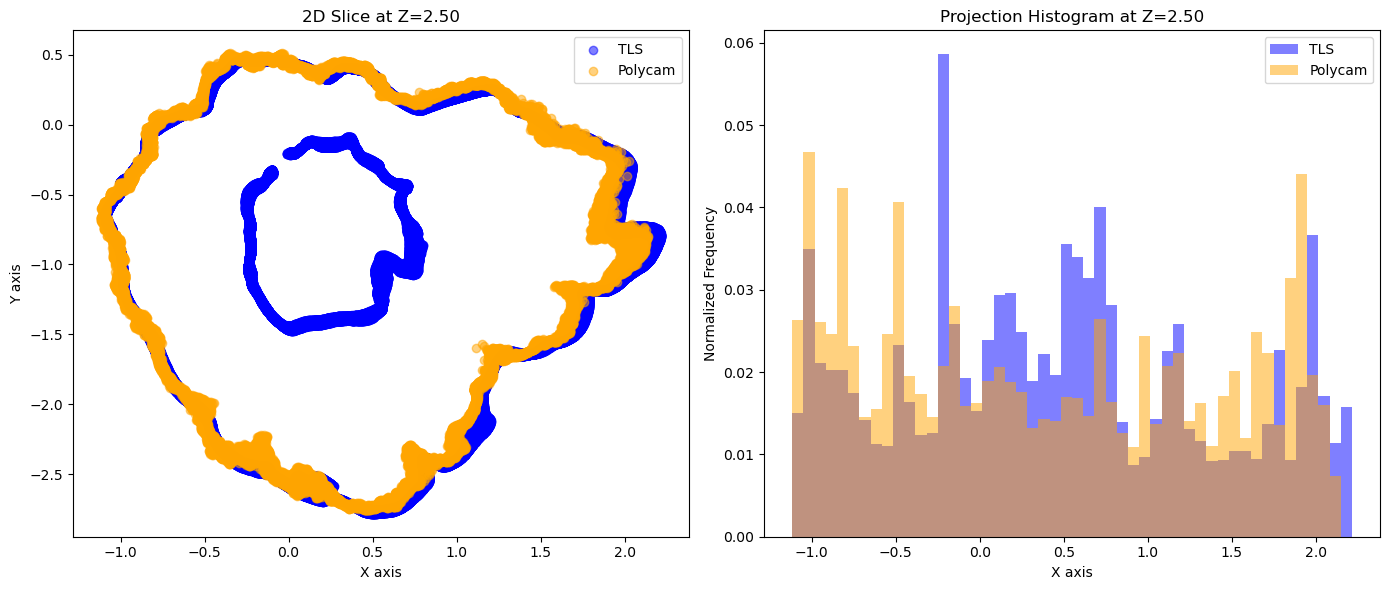

Histogram Ratio Difference at Z=2.50: 0.3984


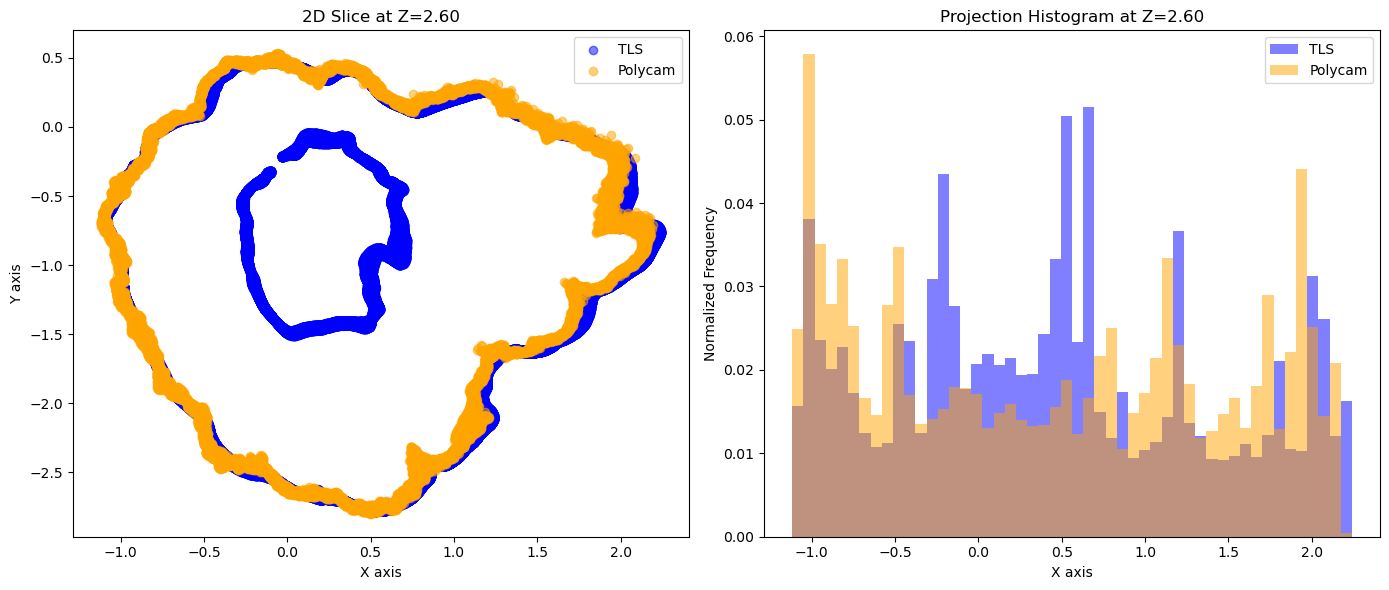

Histogram Ratio Difference at Z=2.60: 0.4496


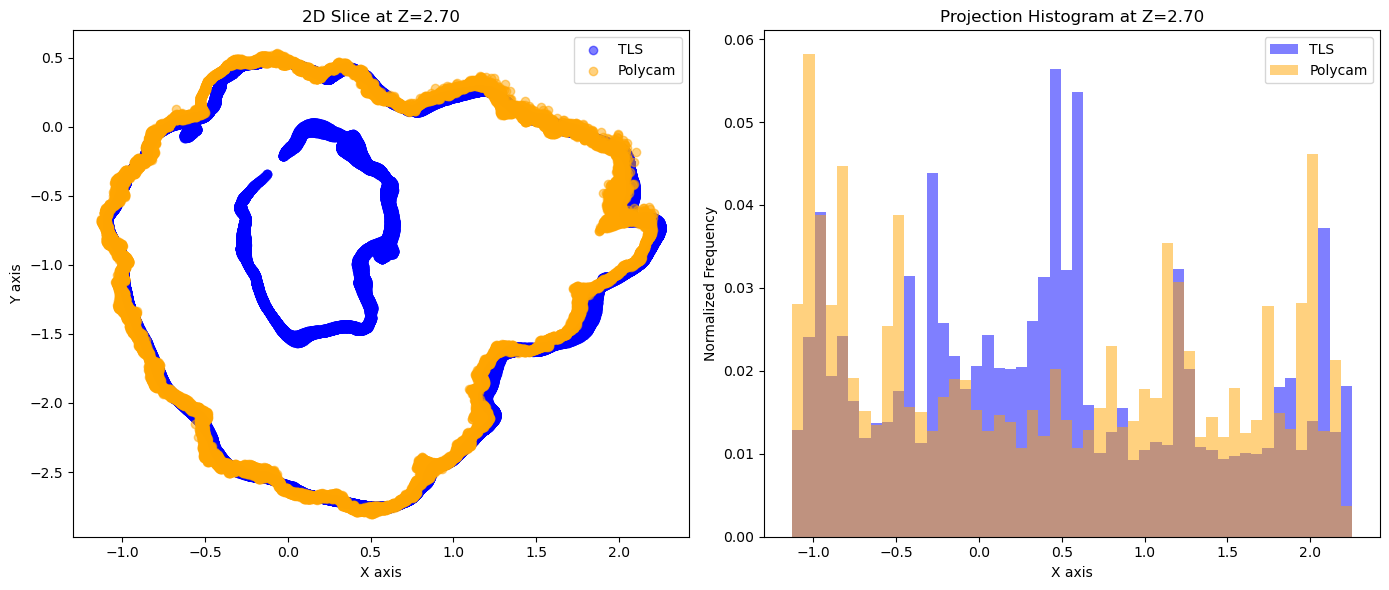

Histogram Ratio Difference at Z=2.70: 0.4704


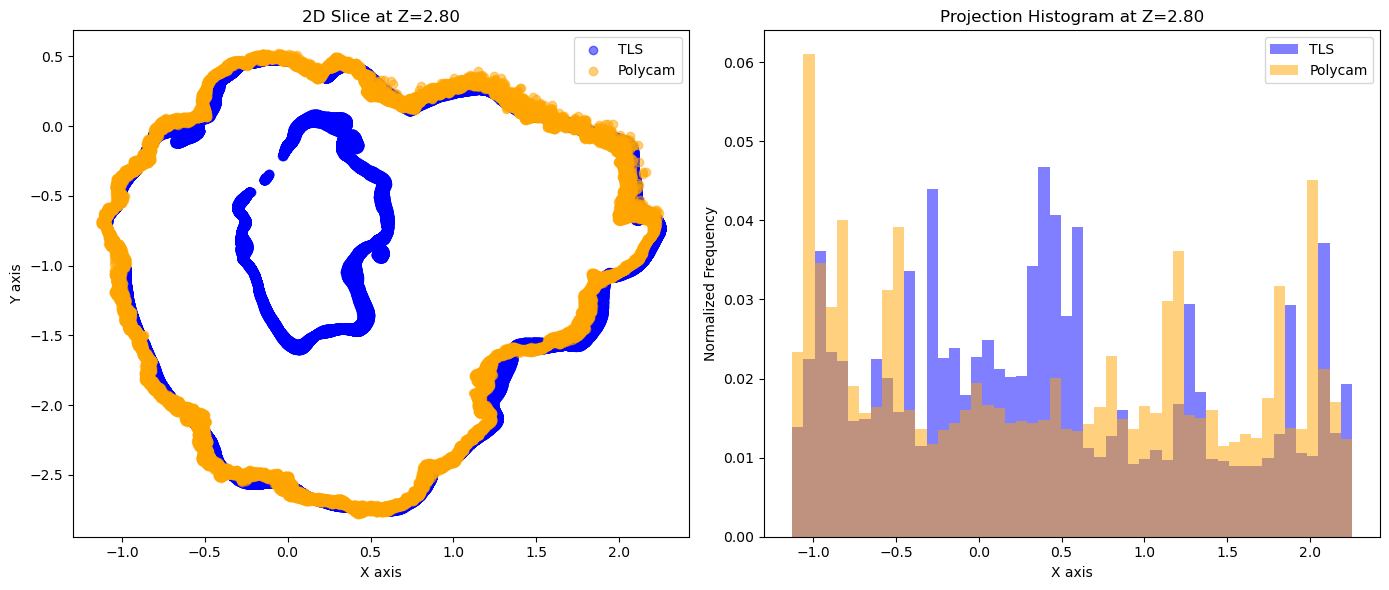

Histogram Ratio Difference at Z=2.80: 0.4852


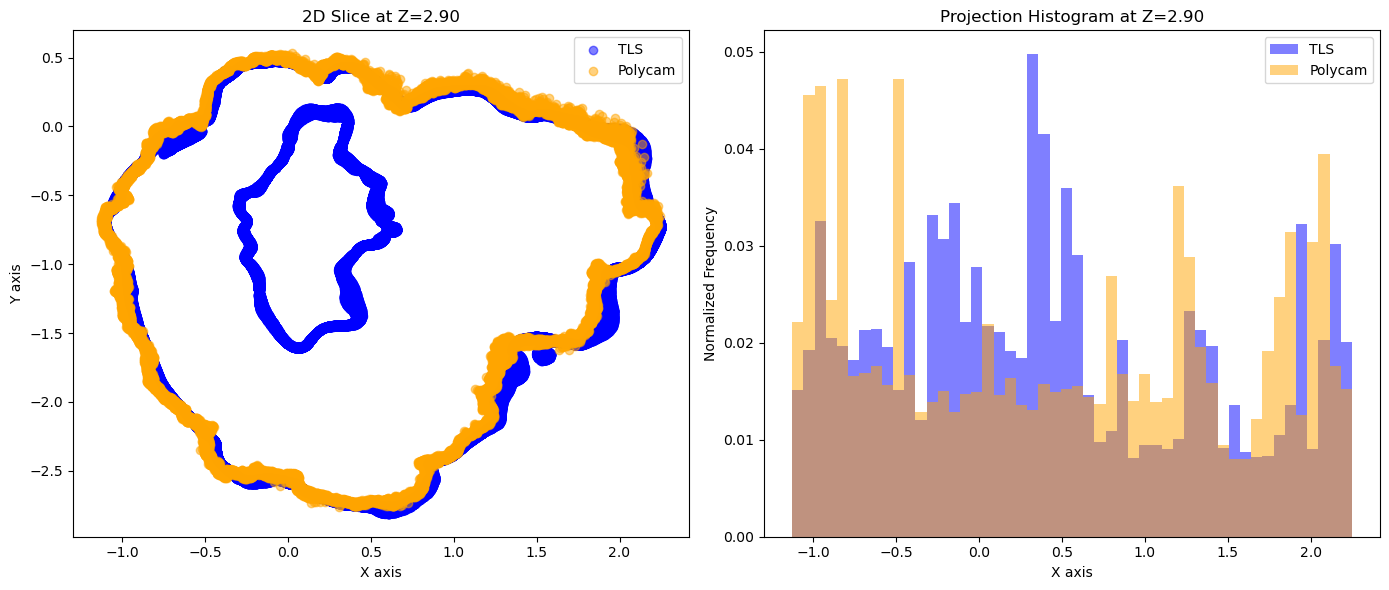

Histogram Ratio Difference at Z=2.90: 0.5291


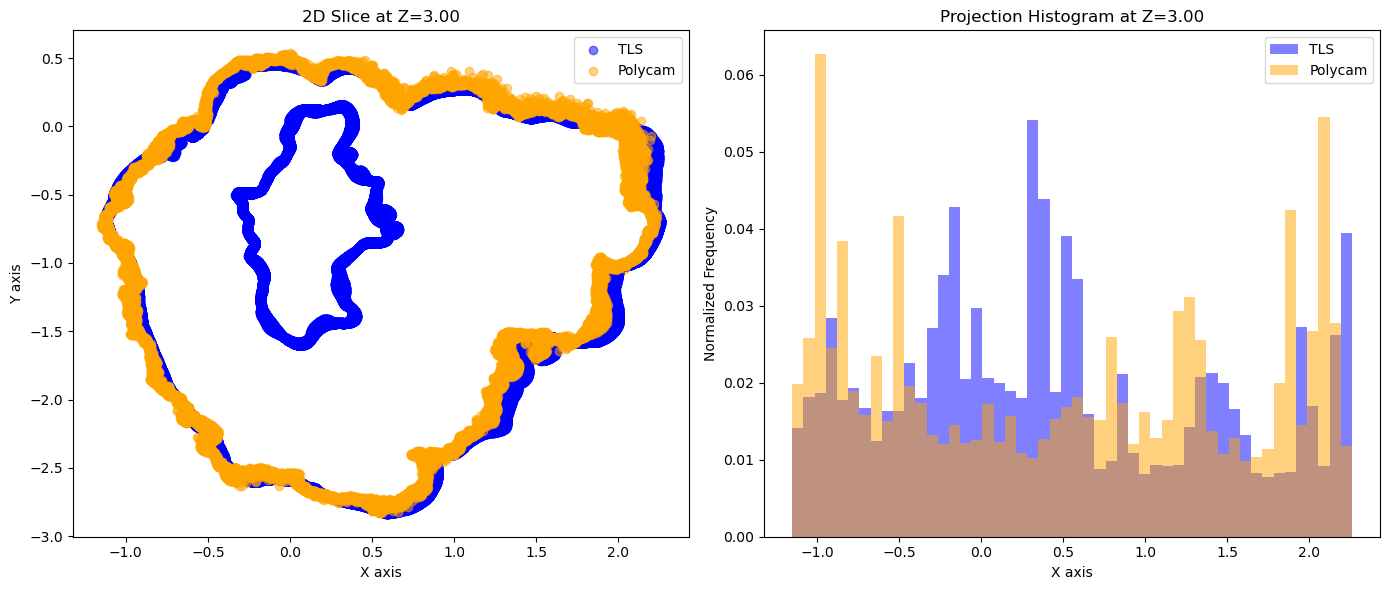

Histogram Ratio Difference at Z=3.00: 0.5639


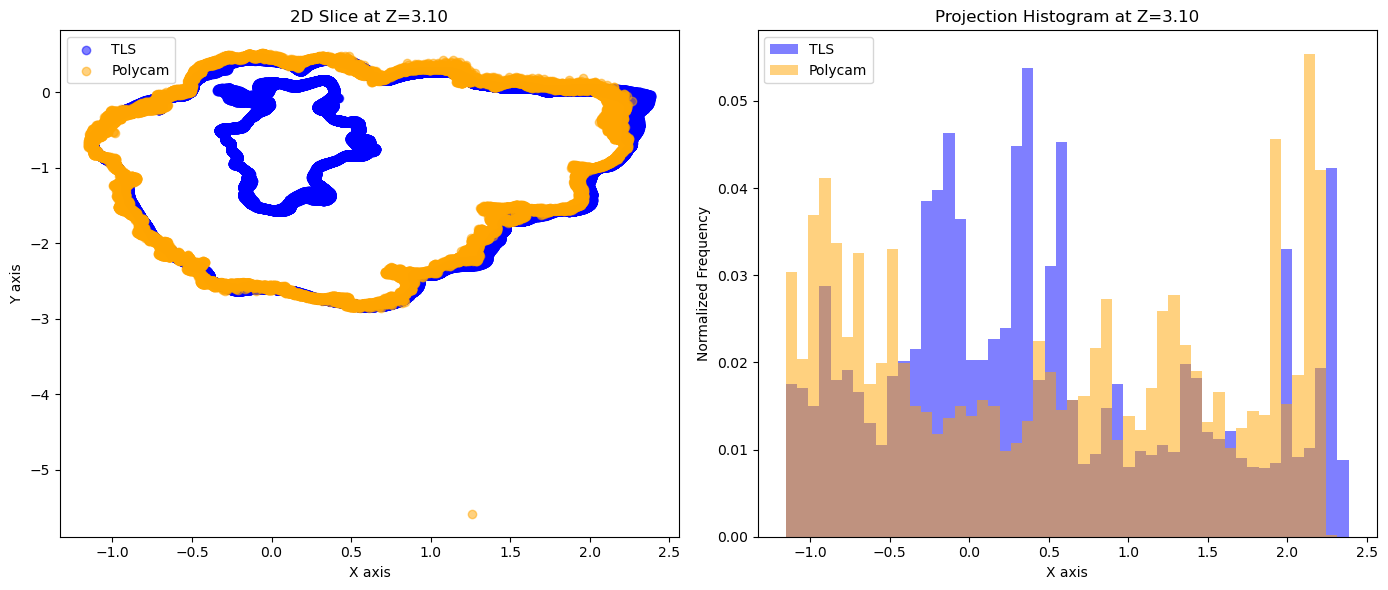

Histogram Ratio Difference at Z=3.10: 0.5545


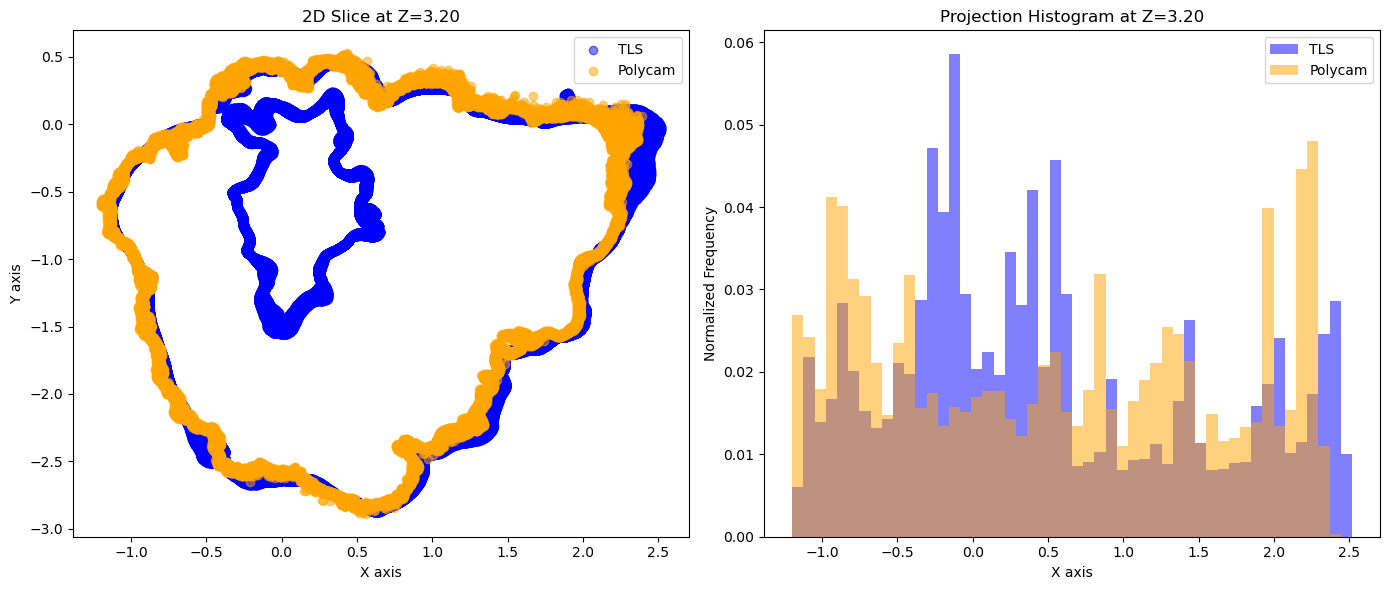

Histogram Ratio Difference at Z=3.20: 0.5201


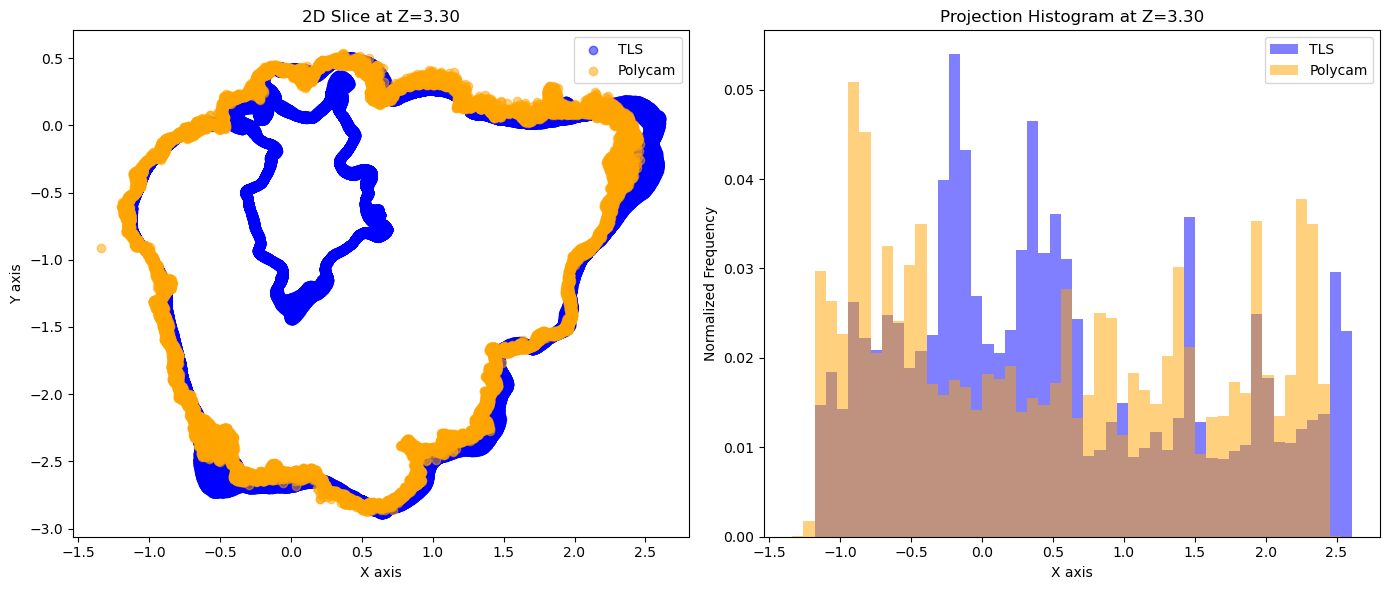

Histogram Ratio Difference at Z=3.30: 0.5316


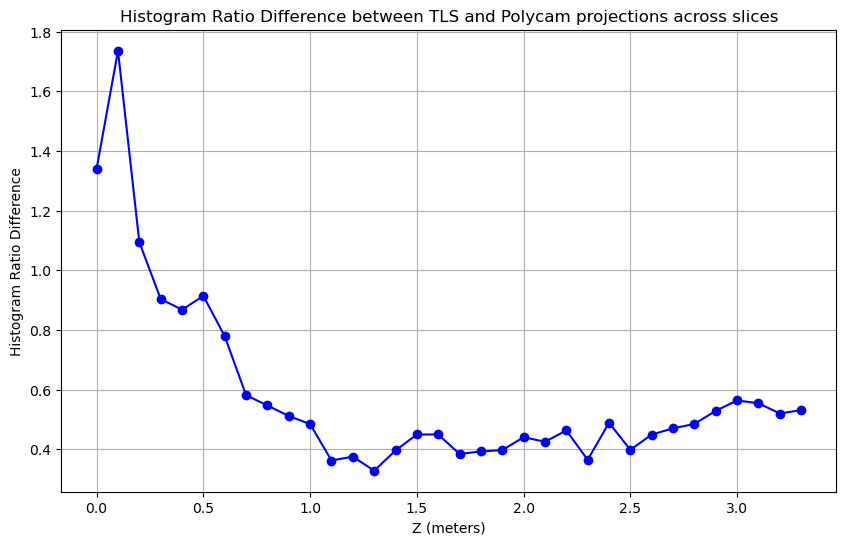

Total Histogram Ratio Difference between TLS and Polycam projections: 19.98375517370453
Average Histogram Ratio Difference per slice: 0.5877575051089567


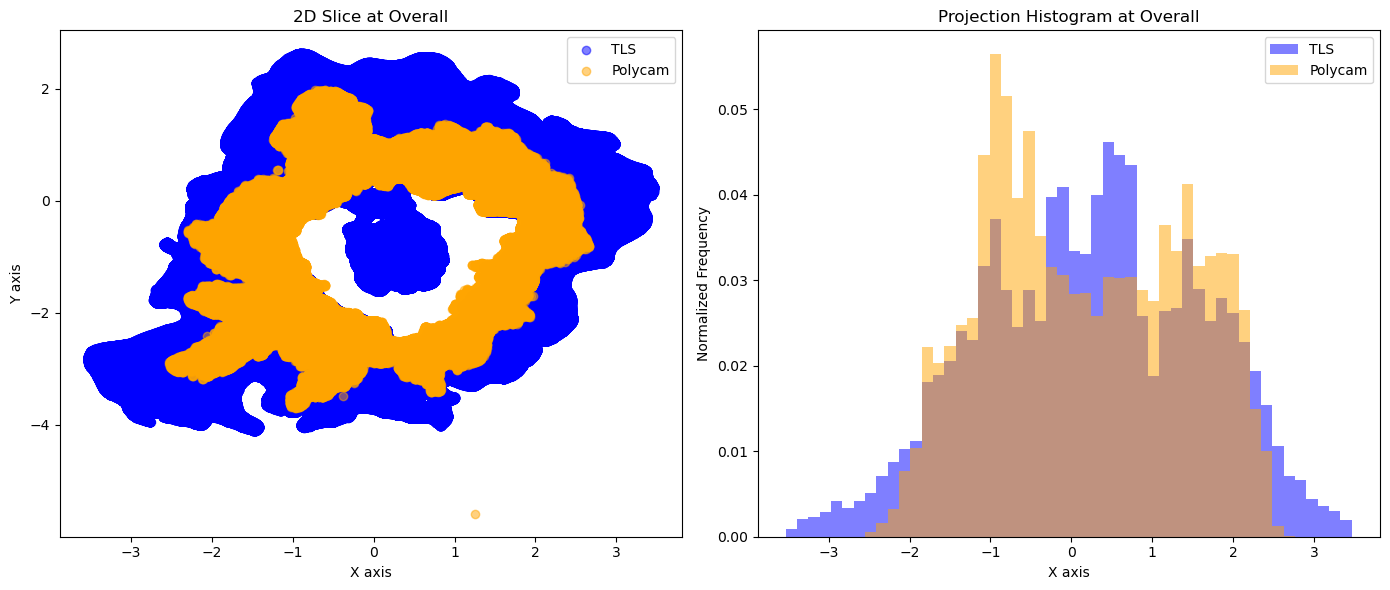

Total Histogram Ratio Difference for overall projection between TLS and Polycam: 0.4028


In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the point cloud data from a PLY file
def load_point_cloud(file_path):
    """
    Load the point cloud data from a PLY file using Open3D.

    Parameters:
    file_path (str): The file path of the PLY file.

    Returns:
    np.ndarray: A NumPy array containing the point cloud data.
    """
    point_cloud = o3d.io.read_point_cloud(file_path)
    return np.asarray(point_cloud.points)

# Normalize the Z values so that the lowest point has a Z value of 0
def normalize_z(points):
    """
    Normalize the Z values of the point cloud so that the lowest point is set to Z=0.

    Parameters:
    points (np.ndarray): A NumPy array containing the point cloud data.

    Returns:
    np.ndarray: The normalized point cloud data with Z=0 as the lowest point.
    """
    z_min = points[:, 2].min()
    points[:, 2] -= z_min
    return points

# Slice the point cloud along the Z axis
def get_slices(points, z_start, z_end, slice_thickness=0.1):
    """
    Slice the point cloud along the Z axis at regular intervals.

    Parameters:
    points (np.ndarray): The point cloud data as a NumPy array.
    z_start (float): The starting Z value for slicing.
    z_end (float): The ending Z value for slicing.
    slice_thickness (float): The thickness of each slice along the Z axis (default is 0.1 meters).

    Returns:
    list: A list of 2D slices, where each slice is a NumPy array of points.
    """
    slices = []
    z_values = np.arange(z_start, z_end, slice_thickness)
    for z in z_values:
        slice_points = points[(points[:, 2] >= z) & (points[:, 2] < z + slice_thickness)]
        if len(slice_points) > 0:
            slices.append(slice_points)
    return slices

# Project the 2D slice points onto the X axis
def project_to_x_axis(slice_points):
    """
    Project the 2D slice points onto the X axis.

    Parameters:
    slice_points (np.ndarray): A NumPy array containing the points in the current slice.

    Returns:
    np.ndarray: The X coordinates of the projected points.
    """
    return slice_points[:, 0]

# Calculate a normalized histogram of point density
def calculate_histogram(projection, bins=50, range=None):
    """
    Calculate a normalized histogram of the point density for the projected points.

    Parameters:
    projection (np.ndarray): The projected X coordinates.
    bins (int): The number of bins for the histogram (default is 50).
    range (tuple): The range of values for the histogram (optional).

    Returns:
    tuple: A tuple containing the histogram and bin edges.
    """
    hist, bin_edges = np.histogram(projection, bins=bins, range=range)
    hist = hist / np.sum(hist)  # Normalize the histogram to total count
    return hist, bin_edges

# Visualize the 2D slice and projection results
def visualize_slice_and_projection(slice_tls, slice_polycam, projection_tls, projection_polycam, z_value, bins=50):
    """
    Visualize the 2D slice and corresponding projection histograms for TLS and Polycam.

    Parameters:
    slice_tls (np.ndarray): The 2D slice points for the TLS data.
    slice_polycam (np.ndarray): The 2D slice points for the Polycam data.
    projection_tls (np.ndarray): The X axis projection of the TLS points.
    projection_polycam (np.ndarray): The X axis projection of the Polycam points.
    z_value (float or str): The Z value of the slice (can be a number or 'Overall' for complete comparison).
    bins (int): The number of bins for the histogram (default is 50).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the 2D slice view for TLS and Polycam
    axes[0].scatter(slice_tls[:, 0], slice_tls[:, 1], color='blue', alpha=0.5, label='TLS')
    axes[0].scatter(slice_polycam[:, 0], slice_polycam[:, 1], color='orange', alpha=0.5, label='Polycam')
    
    if isinstance(z_value, str):
        axes[0].set_title(f'2D Slice at {z_value}')
    else:
        axes[0].set_title(f'2D Slice at Z={z_value:.2f}')
    
    axes[0].set_xlabel('X axis')
    axes[0].set_ylabel('Y axis')
    axes[0].legend()

    # Calculate and plot the projection histograms
    range_min = min(projection_tls.min(), projection_polycam.min())
    range_max = max(projection_tls.max(), projection_polycam.max())
    
    hist_tls, bin_edges = calculate_histogram(projection_tls, bins=bins, range=(range_min, range_max))
    hist_polycam, _ = calculate_histogram(projection_polycam, bins=bins, range=(range_min, range_max))

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    axes[1].bar(bin_centers, hist_tls, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='blue', label='TLS')
    axes[1].bar(bin_centers, hist_polycam, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, color='orange', label='Polycam')

    if isinstance(z_value, str):
        axes[1].set_title(f'Projection Histogram at {z_value}')
    else:
        axes[1].set_title(f'Projection Histogram at Z={z_value:.2f}')

    axes[1].set_xlabel('X axis')
    axes[1].set_ylabel('Normalized Frequency')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Calculate the absolute sum of differences between two histograms
def calculate_histogram_ratio_difference(hist1, hist2):
    """
    Calculate the sum of absolute differences between two histograms.

    Parameters:
    hist1 (np.ndarray): The first histogram.
    hist2 (np.ndarray): The second histogram.

    Returns:
    float: The total absolute difference between the two histograms.
    """
    return np.sum(np.abs(hist1 - hist2))

# Visualize the histogram ratio differences across all slices
def visualize_slice_differences(z_values, differences):
    """
    Visualize the histogram ratio differences across slices.

    Parameters:
    z_values (np.ndarray): An array of Z values representing the height of each slice.
    differences (list): A list of histogram ratio differences between TLS and Polycam for each slice.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(z_values, differences, marker='o', linestyle='-', color='b')
    plt.xlabel('Z (meters)')
    plt.ylabel('Histogram Ratio Difference')
    plt.title('Histogram Ratio Difference between TLS and Polycam projections across slices')
    plt.grid(True)
    plt.show()

# Main function to execute the comparison
def main():
    """
    Main function that executes the comparison of TLS and Polycam point clouds.
    It normalizes the Z values, slices the point clouds, projects the slices onto the X axis,
    and calculates histogram differences, visualizing the results for each slice.
    """
    # Load the point cloud data
    points_tls = load_point_cloud(r"C:\Users\wenru\Desktop\COMPARE\signing polycam.ply")
    points_polycam = load_point_cloud(r"C:\Users\wenru\Desktop\COMPARE\signing TLS.ply")

    # Normalize Z values
    points_tls = normalize_z(points_tls)
    points_polycam = normalize_z(points_polycam)

    # User inputs the Z range for slicing
    z_start = float(input("Enter the start of the Z range (in meters): "))
    z_end = float(input("Enter the end of the Z range (in meters): "))

    # Get slices of the point clouds
    slice_thickness = 0.1  # Set the slice thickness
    slices_tls = get_slices(points_tls, z_start, z_end, slice_thickness)
    slices_polycam = get_slices(points_polycam, z_start, z_end, slice_thickness)

    if len(slices_tls) == 0 or len(slices_polycam) == 0:
        print("No points found in the specified Z range.")
        return

    # Initialize variables to store differences and Z values
    differences = []
    z_values = np.arange(z_start, z_end, slice_thickness)

    # Process each slice, project to X axis, and compare histograms
    for i in range(len(z_values)):
        if i < len(slices_tls) and i < len(slices_polycam):  
            slice_tls = slices_tls[i]
            slice_polycam = slices_polycam[i]

            # Project to X axis
            projection_tls = project_to_x_axis(slice_tls)
            projection_polycam = project_to_x_axis(slice_polycam)

            # Calculate histograms and their differences
            hist_tls, _ = calculate_histogram(projection_tls)
            hist_polycam, _ = calculate_histogram(projection_polycam)

            diff = calculate_histogram_ratio_difference(hist_tls, hist_polycam)
            differences.append(diff)
            
            # Visualize each slice's 2D view and projection histograms
            visualize_slice_and_projection(slice_tls, slice_polycam, projection_tls, projection_polycam, z_values[i])
            
            # Output the ratio difference for each slice
            print(f'Histogram Ratio Difference at Z={z_values[i]:.2f}: {diff:.4f}')
        else:
            differences.append(np.nan)  # For slices without data, add NaN

    # Visualize the histogram ratio differences across slices
    visualize_slice_differences(z_values, differences)

    # Calculate and display total and average differences
    total_diff = np.nansum(differences)  # Ignore NaN values for total difference
    average_diff = np.nanmean(differences)  # Ignore NaN values for average difference

    print(f'Total Histogram Ratio Difference between TLS and Polycam projections: {total_diff}')
    print(f'Average Histogram Ratio Difference per slice: {average_diff}')

    # Filter the point clouds within the user-defined Z range
    points_tls_filtered = points_tls[(points_tls[:, 2] >= z_start) & (points_tls[:, 2] <= z_end)]
    points_polycam_filtered = points_polycam[(points_polycam[:, 2] >= z_start) & (points_polycam[:, 2] <= z_end)]

    # Project the entire Z range onto the X axis and calculate histograms
    overall_projection_tls = project_to_x_axis(points_tls_filtered)
    overall_projection_polycam = project_to_x_axis(points_polycam_filtered)
    
    overall_hist_tls, _ = calculate_histogram(overall_projection_tls)
    overall_hist_polycam, _ = calculate_histogram(overall_projection_polycam)
    
    # Visualize the overall projection results
    overall_diff = calculate_histogram_ratio_difference(overall_hist_tls, overall_hist_polycam)
    visualize_slice_and_projection(points_tls_filtered, points_polycam_filtered, overall_projection_tls, overall_projection_polycam, z_value='Overall')
    
    # Output the overall ratio difference
    print(f'Total Histogram Ratio Difference for overall projection between TLS and Polycam: {overall_diff:.4f}')

if __name__ == "__main__":
    main()
